In this script the standard one class classification models are compared with the Deep One Class Model

# Import the datasets

In [385]:
# Import the libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import percentile
import sys
from matplotlib import rcParams
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [386]:
# Import the labeled dataset after the feature engineering for evaluating the standard one class algorithms
df= pd.read_pickle('/content/drive/My Drive/cocrystal_design-master/data_test/df_reduced.pkl')
df=df.fillna(0)
df.head()

,Identifier,nBM,nHet,ZM1V,DBI,MAXDN,MAXDP,DELS,CIC0,J_D/Dt,SM1_Dz(Z),SM1_Dz(e),HyWi_B(s),SpMax4_Bh(m),SpMax5_Bh(m),SpMax3_Bh(s),SpMax7_Bh(s),P_VSA_v_2,P_VSA_s_6,Eta_F_A,Eig02_AEA(dm),Eig03_AEA(dm),Eig04_AEA(dm),nHAcc,Uc,nBM,nHet,ZM1V,DBI,MAXDN,MAXDP,DELS,CIC0,J_D/Dt,SM1_Dz(Z),SM1_Dz(e),HyWi_B(s),SpMax4_Bh(m),SpMax5_Bh(m),SpMax3_Bh(s),SpMax7_Bh(s),P_VSA_v_2,P_VSA_s_6,Eta_F_A,Eig02_AEA(dm),Eig03_AEA(dm),Eig04_AEA(dm),nHAcc,Uc
0,WOVMEB,0.034483,0.000000,0.018611,0.073325,0.027142,0.008182,0.001948,0.280067,0.039639,0.294727,0.488984,0.124624,0.134999,0.115762,0.125998,0.141539,0.000000,0.000000,0.401869,0.129363,0.248306,0.200778,0.000000,0.376728,0.344828,0.533333,0.437366,0.586596,0.224855,0.042956,0.069420,0.690742,0.272679,0.955695,0.325775,0.635607,0.354941,0.362241,0.321908,0.493806,0.000000,0.000000,0.449448,0.498103,0.607893,0.667916,0.000000,0.796001
1,PIWKEL,0.057471,0.088889,0.116679,0.146649,0.184005,0.368062,0.063556,0.321768,0.186531,0.461594,0.635722,0.516301,0.217960,0.220841,0.820058,0.449921,0.258007,0.171279,0.555367,0.458649,0.571816,0.640098,0.105263,0.464233,0.017241,0.088889,0.069435,0.073325,0.021423,0.008932,0.001714,0.125271,0.042391,0.596436,0.542460,0.168092,0.194568,0.189278,0.062123,0.099236,0.000000,0.000000,0.279807,0.709408,0.604336,0.668781,0.000000,0.268420
2,OTIHIJ,0.195402,0.044444,0.147459,0.302317,0.110113,0.024137,0.020041,0.600334,0.104237,0.355165,0.541176,0.495260,0.273070,0.264834,0.305550,0.471929,0.016030,0.000000,0.611725,0.415781,0.509824,0.583453,0.052632,0.688364,0.034483,0.000000,0.012885,0.000000,0.000000,0.000000,0.000000,0.180984,0.028090,0.294727,0.488984,0.073064,0.000000,0.026221,0.090555,0.005535,0.000000,0.000000,0.408383,0.007018,0.169377,0.010378,0.000000,0.376728
3,DABLOJ,0.005747,0.044444,0.027201,0.163954,0.170389,0.192418,0.012151,0.154962,0.000000,0.392247,0.574759,0.228439,0.092873,0.024764,0.108861,0.047443,0.092719,0.061552,0.365619,0.161419,0.086551,0.131306,0.052632,0.134210,0.126437,0.111111,0.162491,0.336046,0.288217,0.317196,0.062585,0.551626,0.136339,0.424512,0.601070,0.571098,0.251066,0.251627,0.695813,0.498814,0.326708,0.211564,0.615973,0.644917,0.659383,0.715624,0.131579,0.607167
4,PIGJUK,0.074713,0.088889,0.110952,0.179572,0.027324,0.022024,0.007123,0.349291,0.169320,0.596436,0.542460,0.328324,0.244920,0.246965,0.200779,0.360569,0.000000,0.000000,0.428207,0.758915,0.675305,0.716777,0.000000,0.510938,0.057471,0.088889,0.105941,0.253996,0.146514,0.194122,0.037155,0.311259,0.107193,0.403564,0.582888,0.490867,0.216870,0.210450,0.695813,0.443068,0.318692,0.211564,0.558482,0.623293,0.655318,0.712165,0.105263,0.464233


In [4]:
# Set up the path for importing the python codes need
sys.path.extend(['/content/drive/My Drive/cocrystal_design/models/pyod', '/content/drive/My Drive/cocrystal_design/models',
                 '/content/drive/My Drive/cocrystal_design/notebooks/python_codes', '/content/drive/My Drive/cocrystal_design/models' ])


In [5]:
#Install the pyod library
!git clone https://github.com/yzhao062/pyod.git
%cd pyod
!pip install .

Cloning into 'pyod'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 6561 (delta 12), reused 21 (delta 6), pack-reused 6522
Receiving objects: 100% (6561/6561), 35.36 MiB | 31.35 MiB/s, done.
Resolving deltas: 100% (4573/4573), done.
/content/pyod
Processing /content/pyod
     |████████████████████████████████| 2.1MB 5.9MB/s 
  Created wheel for pyod: filename=pyod-0.8.1-cp36-none-any.whl size=170458 sha256=7242dfba676eefaea44cf6465b90f6dd18c77c6aba961b5f2974518f4747f078
  Stored in directory: /tmp/pip-ephem-wheel-cache-s412fb50/wheels/e9/f5/0e/d4503681e4cf321c8fcc6a71c0bacc4880ce0d428d14540070
  Created wheel for combo: filename=combo-0.1.1-cp36-none-any.whl size=42111 sha256=a5ccc6a05266022b4dac6cff6ee85c1cb0bf9638f3eb1ee89d01a3ff0c738d78
  Stored in directory: /root/.cache/pip/wheels/55/ec/e5/a2331372c676c467e70c6646e646edf6997d5c4905b8c0f5e6
  Created wheel for suod: filename=suod-

# Evaluate the standard models

In [387]:
# Import all models
from pyod.models.abod import ABOD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.cblof import CBLOF
from sklearn.mixture import GaussianMixture
from sklearn.utils import (indexable, check_random_state, _safe_indexing,
                     _message_with_time)
from sklearn.model_selection._split import check_cv
from sklearn.base import is_classifier, clone
from sklearn.metrics import check_scoring
from joblib import Parallel, delayed
from sklearn.utils.validation import _check_fit_params
import time
from sklearn.utils.metaestimators import _safe_split
from sklearn.model_selection._validation import _translate_train_sizes
from sklearn.utils import (indexable, check_random_state, _safe_indexing,
                     _message_with_time)
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from contextlib import suppress
from sklearn.model_selection import ShuffleSplit
import numbers
import warnings


## Calculate the learing curves for the standard models

In [8]:
# Built an ensemble of all the implemented algorithms
from sklearn.base import BaseEstimator

class Ensemble(BaseEstimator):
  def __init__(self, classifiers):
    self.classifiers = classifiers

  def fit(self, X, y):
    for clf in classifiers.values():
      clf.fit(X, y)

  def predict(self, X):
    scores = []
    for clf in classifiers.values():
      scores.append(clf.predict(X))
     
    return (np.mean(scores, 0) >= 0.5).astype('int').ravel()


In [119]:
# Built the Gaussian Mixture Classifier to be used for anomaly detection
from sklearn.base import BaseEstimator
contamination =0.05


class GMM(GaussianMixture):
  def __init__(self, n_components, covariance_type, random_state):
    super().__init__(n_components=n_components , covariance_type=covariance_type, random_state=random_state)

  def fit(self, X, y):
    super().fit(X, y)
    self.prob = super().score_samples(X)
    self.c = percentile(self.prob, 100 * contamination)

  def predict(self, X):
    scores = []
    proba=super().score_samples(X)
    
    scores =(proba <= self.c).astype('int').ravel()
     
    return scores

In [120]:
from sklearn.utils import (indexable, check_random_state, _safe_indexing,
                     _message_with_time)

from sklearn.model_selection._split import check_cv

from sklearn.base import is_classifier, clone
from sklearn.metrics import check_scoring
from joblib import Parallel, delayed
from sklearn.utils.validation import _check_fit_params
import time
from sklearn.utils.metaestimators import _safe_split
from sklearn.model_selection._validation import _translate_train_sizes
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from contextlib import suppress
import numbers
import warnings

In [121]:
def _fit_and_score(estimator, X, y, scorer, train, test, verbose,
                   parameters, fit_params, return_train_score=False,
                   return_parameters=False, return_n_test_samples=False,
                   return_times=False, return_estimator=False,
                   error_score=np.nan):

    if verbose > 1:
        if parameters is None:
            msg = ''
        else:
            msg = '%s' % (', '.join('%s=%s' % (k, v)
                          for k, v in parameters.items()))
        print("[CV] %s %s" % (msg, (64 - len(msg)) * '.'))

    # Adjust length of sample weights
    fit_params = fit_params if fit_params is not None else {}
    fit_params = _check_fit_params(X, fit_params, train)

    train_scores = {}
    if parameters is not None:
        # clone after setting parameters in case any parameters
        # are estimators (like pipeline steps)
        # because pipeline doesn't clone steps in fit
        cloned_parameters = {}
        for k, v in parameters.items():
            cloned_parameters[k] = clone(v, safe=False)

        estimator = estimator.set_params(**cloned_parameters)

    start_time = time.time()

    X_train, y_train = _safe_split(estimator, X, y, train)
    X_train = pd.concat([X_train, pd.concat([X_train.iloc[:, 24:], X_train.iloc[:, :24]], axis=1)]) #pd.concat([X_train.iloc[:, :24], X_train.iloc[:, 24:]], axis=1),
    y_train = np.concatenate([y_train, y_train])
    X_test, y_test = _safe_split(estimator, X, y, test, train)

    try:
        if y_train is None:
            estimator.fit(X_train, **fit_params)
        else:
            estimator.fit(X_train, y_train, **fit_params)

    except Exception as e:
        # Note fit time as time until error
        fit_time = time.time() - start_time
        score_time = 0.0
        if error_score == 'raise':
            raise
        elif isinstance(error_score, numbers.Number):
            if isinstance(scorer, dict):
                test_scores = {name: error_score for name in scorer}
                if return_train_score:
                    train_scores = test_scores.copy()
            else:
                test_scores = error_score
                if return_train_score:
                    train_scores = error_score
            warnings.warn("Estimator fit failed. The score on this train-test"
                          " partition for these parameters will be set to %f. "
                          "Details: \n%s" %
                          (error_score, format_exception_only(type(e), e)[0]),
                          FitFailedWarning)
        else:
            raise ValueError("error_score must be the string 'raise' or a"
                             " numeric value. (Hint: if using 'raise', please"
                             " make sure that it has been spelled correctly.)")

    else:
        fit_time = time.time() - start_time
        test_scores = _score(estimator, X_test, y_test, scorer)
        score_time = time.time() - start_time - fit_time
        if return_train_score:
            train_scores = _score(estimator, X_train, y_train, scorer)
    if verbose > 2:
        if isinstance(test_scores, dict):
            for scorer_name in sorted(test_scores):
                msg += ", %s=" % scorer_name
                if return_train_score:
                    msg += "(train=%.3f," % train_scores[scorer_name]
                    msg += " test=%.3f)" % test_scores[scorer_name]
                else:
                    msg += "%.3f" % test_scores[scorer_name]
        else:
            msg += ", score="
            msg += ("%.3f" % test_scores if not return_train_score else
                    "(train=%.3f, test=%.3f)" % (train_scores, test_scores))

    if verbose > 1:
        total_time = score_time + fit_time
        print(_message_with_time('CV', msg, total_time))

    ret = [train_scores, test_scores] if return_train_score else [test_scores]

    if return_n_test_samples:
        ret.append(_num_samples(X_test))
    if return_times:
        ret.extend([fit_time, score_time])
    if return_parameters:
        ret.append(parameters)
    if return_estimator:
        ret.append(estimator)
    return ret


def _score(estimator, X_test, y_test, scorer):
    """Compute the score(s) of an estimator on a given test set.
    Will return a dict of floats if `scorer` is a dict, otherwise a single
    float is returned.
    """
    if isinstance(scorer, dict):
        # will cache method calls if needed. scorer() returns a dict
        scorer = _MultimetricScorer(**scorer)
    if y_test is None:
        scores = scorer(estimator, X_test)
    else:
        scores = scorer(estimator, X_test, y_test)

    error_msg = ("scoring must return a number, got %s (%s) "
                 "instead. (scorer=%s)")
    if isinstance(scores, dict):
        for name, score in scores.items():
            if hasattr(score, 'item'):
                with suppress(ValueError):
                    # e.g. unwrap memmapped scalars
                    score = score.item()
            if not isinstance(score, numbers.Number):
                raise ValueError(error_msg % (score, type(score), name))
            scores[name] = score
    else:  # scalar
        if hasattr(scores, 'item'):
            with suppress(ValueError):
                # e.g. unwrap memmapped scalars
                scores = scores.item()
        if not isinstance(scores, numbers.Number):
            raise ValueError(error_msg % (scores, type(scores), scorer))
    return scores


In [388]:
def learning_curve(estimator, X, y, groups=None,
                   train_sizes=np.linspace(0.1, 1.0, 5), cv=None,
                   scoring=None, exploit_incremental_learning=False,
                   n_jobs=None, pre_dispatch="all", verbose=0, shuffle=False,
                   random_state=None, error_score=np.nan, return_times=False):
  
    X, y, groups = indexable(X, y, groups)

    if exploit_incremental_learning and not hasattr(estimator, "partial_fit"):
        raise ValueError("An estimator must support the partial_fit interface "
                         "to exploit incremental learning")
    X, y, groups = indexable(X, y, groups)

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    # Store it as list as we will be iterating over the list multiple times
    cv_iter = list(cv.split(X, y, groups))

    scorer = check_scoring(estimator, scoring=scoring)

    n_max_training_samples = len(cv_iter[0][0])
    # Because the lengths of folds can be significantly different, it is
    # not guaranteed that we use all of the available training data when we
    # use the first 'n_max_training_samples' samples.
    train_sizes_abs = _translate_train_sizes(train_sizes,
                                             n_max_training_samples)
    n_unique_ticks = train_sizes_abs.shape[0]
    if verbose > 0:
        print("[learning_curve] Training set sizes: " + str(train_sizes_abs))

    parallel = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch,
                        verbose=verbose)

    if shuffle:
        rng = check_random_state(random_state)
        cv_iter = ((rng.permutation(train), test) for train, test in cv_iter)

    if exploit_incremental_learning:
        classes = np.unique(y) if is_classifier(estimator) else None
        out = parallel(delayed(_incremental_fit_estimator)(
            clone(estimator), X, y, classes, train, test, train_sizes_abs,
            scorer, verbose, return_times) for train, test in cv_iter)
    else:
        train_test_proportions = []
        for train, test in cv_iter:
            for n_train_samples in train_sizes_abs:
                train1 = train[:n_train_samples]
                train_test_proportions.append((train1, test))

        out = parallel(delayed(_fit_and_score)(
            clone(estimator), X, y, scorer, train, test, verbose,
            parameters=None, fit_params=None, return_train_score=True,
            error_score=error_score, return_times=return_times)
            for train, test in train_test_proportions)
        out = np.array(out)
        n_cv_folds = out.shape[0] // n_unique_ticks
        dim = 4 if return_times else 2
        out = out.reshape(n_cv_folds, n_unique_ticks, dim)

    out = np.asarray(out).transpose((2, 1, 0))

    ret = train_sizes_abs, out[0], out[1]

    if return_times:
        ret = ret + (out[2], out[3])

    return ret


In [389]:
# The hyperparameters were selected after Bayesian Optimization using the hyperopt library
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 6, covariance_type='spherical', random_state=0), 
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 17, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)':  HBOS(contamination=0.05, n_bins=15, alpha=0.7), 
    'Feature Bagging': FeatureBagging(LOF(n_neighbors=8), contamination=0.05,  random_state=0),
        'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000, random_state=0),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=7), 
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=10, contamination=0.05), 
    'CBLOF':  CBLOF(contamination=0.05,  beta=4, n_clusters=10)
 }

In [390]:
# Calculate the learning curves of the Ensemble

#from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score

X_train=df.iloc[:1722, 1:]
y=np.zeros(X_train.shape[0])

clf  = Ensemble(classifiers) 

scoring = make_scorer(accuracy_score)
train_sizes=np.linspace(.02, 1.0, 20)

train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(clf, X_train, y , scoring = scoring ,train_sizes=train_sizes, 
                       random_state= 0, return_times=True)

train_sizes = train_sizes*2        
train_scores_mean_ens = np.mean(train_scores, axis=1)*100
train_scores_std_ens = np.std(train_scores, axis=1)*100
test_scores_mean_ens = np.mean(test_scores, axis=1)*100
test_scores_std_ens = np.std(test_scores, axis=1)*100

print(train_sizes)
print(test_scores_mean_ens)
test_scores_std_ens

[  54  196  338  480  622  764  906 1048 1190 1332 1474 1616 1758 1900
 2042 2184 2326 2468 2610 2754]
[75.62386249 68.77064375 68.76946411 73.18385575 77.82912032 83.2834513
 83.86299292 84.85102797 83.74890462 84.44641052 85.72514324 90.07381193
 92.9735423  92.97371082 93.61172902 93.4388271  93.67087968 93.72918773
 93.32339063 93.44000674]


array([16.73188838, 13.43523473, 12.55544265, 16.3661595 , 18.26080648,
       12.31071101, 11.82233072, 11.50320055, 13.53049267, 13.73800559,
       13.27955088,  5.30047881,  1.81320846,  1.58368165,  1.77370242,
        2.07949447,  2.27880228,  2.66145072,  3.3358825 ,  3.24069749])

In [391]:
#from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy=[]
std=[]

X_train=df.iloc[:1722, 1:]
y=np.zeros(X_train.shape[0])
scoring = make_scorer(accuracy_score)
train_sizes=np.linspace(.02, 1.0, 20)

for i, (clf_name, clf) in enumerate(classifiers.items()):
  train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(clf, X_train, y , scoring = scoring ,train_sizes=train_sizes, random_state= 0,
                       return_times=True)        
  train_scores_mean = np.mean(train_scores, axis=1)*100
  train_scores_std = np.std(train_scores, axis=1)*100
  test_scores_mean = np.mean(test_scores, axis=1)*100
  test_scores_std = np.std(test_scores, axis=1)*100
  accuracy.append(test_scores_mean)
  std.append(test_scores_std)

In [392]:
accuracy

[array([57.96865521, 73.2413212 , 71.96124031, 75.91051567, 78.46477924,
        89.37714863, 88.97286822, 89.89821368, 88.27350859, 87.40933603,
        86.53690597, 89.84024267, 90.53623188, 91.98651837, 93.43916414,
        93.26407145, 93.78833839, 93.49780923, 93.03437816, 92.16464442]),
 array([82.47000337, 69.05746545, 70.74031008, 73.70357263, 80.15166835,
        84.15217391, 84.38355241, 86.82574992, 85.89770812, 85.72446916,
        87.23289518, 91.92905292, 92.56673407, 92.33434446, 92.45011796,
        92.62453657, 93.08897877, 93.37900236, 92.97253118, 93.08897877]),
 array([81.90562858, 79.57532861, 76.14560162, 73.35355578, 76.77974385,
        77.30097742, 78.6380182 , 78.98668689, 79.33569262, 80.2660937 ,
        82.2421638 , 85.90023593, 90.07751938, 90.77451972, 91.00724638,
        91.00792046, 90.89079879, 90.60128075, 90.66009437, 91.00893158]),
 array([78.93276036, 75.27957533, 72.25766768, 80.03960229, 83.52578362,
        90.13211999, 90.30502191, 89.89888777

### Calculate k-fold cross validation for the standard models

In [393]:
import pandas as pd
import numpy as np
from sklearn import metrics

def cross_val(clf):
  valid =[]
  X_train_val=pd.concat([pd.DataFrame(X_train.values), pd.DataFrame(np.zeros(len(X_train)))], axis=1)

  # Perform k-fold cross validation
  from sklearn.model_selection import KFold
  kf = KFold(n_splits = 5, random_state=0)
  kf.get_n_splits(X_train_val)
  for train, test in kf.split(X_train_val):
      train_data = np.array(X_train_val)[train]
      train_label = train_data[:,-1]
      test_data = np.array(X_train_val)[test]
      test_label = test_data[:, -1]
      train_data = np.vstack([train_data, np.hstack([train_data[:,24:], train_data[:,:24]])])
      train_label = np.concatenate([train_label, train_label])
      clf.fit(train_data[:, :-1],train_label )
      pred_train = clf.predict(train_data[:,:-1])
      pred_test = clf.predict(test_data[:,:-1])
      valid.append(metrics.accuracy_score(pred_test, test_label))
  return valid

In [394]:
from random import Random
from sklearn.model_selection import KFold
val_list = []
df=df.fillna(0)
X_train= df.iloc[:, 1:]
X_train_val=pd.concat([pd.DataFrame(X_train.values), pd.DataFrame(np.zeros(len(X_train)))], axis=1)

kf = KFold(n_splits = 5,   shuffle=True,  random_state=0)

for i, (clf_name, clf) in enumerate(classifiers.items()):
  k = cross_val(clf)
  val_list.append(k)


In [395]:
#Calcualte the k-fold accuracy of the ensemble

clf_ens = Ensemble(classifiers)
ens_kfold = cross_val(clf_ens)

In [396]:
print(np.mean(val_list, 1))
print(np.std(val_list, 1))

[0.9305954  0.93001401 0.92277652 0.93437658 0.92392117 0.90881839
 0.9346639  0.92190063]
[0.02036901 0.01873622 0.04905902 0.00859878 0.02727008 0.01697165
 0.01078315 0.02299361]


In [397]:
print(np.mean(ens_kfold, 0)) #9422
print(np.std(ens_kfold, 0))


0.9401787221115875
0.015382400416245955


# Evaluate the deep network

### Calculate the learning curve for the neural network

In [ ]:
# Import the neural network architectures and libraries

%cd /content/drive/My Drive/cocrystal_design-master/models/deep_one_class/src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
#from utils.visualization.plot_images_grid import plot_images_grid
import deepSVDD
from base.base_net import BaseNet



/content/drive/My Drive/cocrystal_design-master/models/deep_one_class/src/set_transformer
/content/drive/My Drive/cocrystal_design-master/models/deep_one_class/src


In [ ]:
INPUT_DIM = 3714

class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if data is None:
          self.data=labelled.values.astype('f')

        else:

          self.data = pd.concat([pd.concat([pd.DataFrame(data).iloc[:, 1857:],pd.DataFrame(data).iloc[:,:1857] ], axis=1),
                               pd.concat([pd.DataFrame(data).iloc[:, :1857], pd.DataFrame(data).iloc[:,1857:] ], axis=1)  ]).values.astype('f')
          #self.data = data.values.astype('f')
        self.labels = np.zeros(self.data.shape[0])
          

    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [ ]:
INPUT_DIM =  1857

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=1857, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=5),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))
        
    def forward(self, x):
      x = torch.split(x, 1857, dim=1)     
      x= torch.stack(x).transpose(0,1) 
      return self.seq(x).squeeze()

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder =  nn.Sequential( nn.Linear(in_features=100, out_features=500), nn.LeakyReLU(),
        nn.Linear(in_features=500, out_features=1000),nn.LeakyReLU(),
        nn.Linear(in_features=1000, out_features=1857),nn.LeakyReLU(),                                       
          nn.Linear(in_features=1857, out_features=3714), nn.Sigmoid())
        self.decoder.apply(init_weights)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:

def build_autoencoder(net_name):
    return PairsAutoEncoder()
    #return nn.Sequential()~

def build_network(net_name):
  
  return PairsEncoder()
    #return nn.Sequential()
torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [ ]:

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [ ]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': -1, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'} )

In [ ]:
df = pd.read_pickle("/content/drive/My Drive/cocrystal_design-master/data/df_labelled_scaled.pkl")
labelled = df.iloc[:1722, 1:]

In [ ]:
dataset_name = cfg.settings['dataset_name']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0
dataset = Pairs_Dataset('', data=df.iloc[:, 1:])

In [ ]:
torch.manual_seed(0)
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from sklearn import metrics
scores1=[]

def Average(lst): 
    return sum(lst) / len(lst) 
def deep_one_test(trainer, dataset: Pairs_Dataset(''), net: BaseNet, threshold=None):
        logger = logging.getLogger()
        nu = 0.05
        # Set device for network
        device = 'cuda'
        net = net.to(trainer.device)        
        if threshold == None:
          threshold = get_R(trainer, dataset, net, nu)           
        
        #print('Thres:', threshold)
        # Get test data loader
        _, test_loader = dataset.loaders(batch_size=trainer.batch_size, num_workers=trainer.n_jobs_dataloader)

        # Testing
        logger.info('Starting testing...')
        #start_time = time.time()
        idx_label_score = []
        net.eval()
        
        all_scores=[]
        with torch.no_grad():
             
          for data in test_loader:
            inputs, labels, idx = data
                
                #labels = np.zeros(pd.DataFrame(labels).shape[0])
            inputs = inputs.to(trainer.device)
            outputs = net(inputs)
            dist = torch.sum((outputs - trainer.c) ** 2, dim=1)
            if trainer.objective == 'soft-boundary':
              scores = dist - trainer.R ** 2
            else:
             scores = dist.cpu().numpy()
             all_scores.append(scores)
        
        scores = np.concatenate(all_scores)
        #print(scores)
       
        #print('threshold', threshold)
        scores = np.array(scores)
        #print(np.min(scores), np.mean(scores), np.median(scores), np.max(scores))
        
        scores = (scores > threshold ).astype(np.int)
        score = (scores == 0).sum()

        # Compute AUC
        labels = np.zeros_like(scores)
        trainer.test_auc = metrics.accuracy_score(labels, scores, normalize=True)
        logger.info('Test set accuracy: {:.2f}%'.format(100*trainer.test_auc))
        scores1  = (100*trainer.test_auc)
        #print("Average Accuracy: {:.2f}%".format(Average(scores1)))
        #print("Standard Deviation: {:.2f}%".format(np.std(scores1)))
        logger.info('Finished testing.')
        return labels, scores, scores1, threshold

In [ ]:
from optim.ae_trainer import AETrainer
def pretrain(deepSVDD, dataset, optimizer_name: str = 'adam', lr: float = 1e-5, n_epochs: int = 50,
             lr_milestones: tuple = (), batch_size: int = 200, weight_decay: float = 1e-3, device: str = 'cuda',
             n_jobs_dataloader: int = 0):
    """Pretrains the weights for the Deep SVDD network \phi via autoencoder."""

    deepSVDD.ae_net = build_autoencoder(deepSVDD.net_name)
    deepSVDD.ae_optimizer_name = optimizer_name
    deepSVDD.ae_trainer = AETrainer(optimizer_name, lr=lr, n_epochs=n_epochs, lr_milestones=lr_milestones,
                                batch_size=batch_size, weight_decay=weight_decay, device=device,
                                n_jobs_dataloader=n_jobs_dataloader)
    deepSVDD.ae_net = deepSVDD.ae_trainer.train(dataset, deepSVDD.ae_net)
    deepSVDD.init_network_weights_from_pretraining()

In [ ]:
def get_R(trainer, dataset, net, nu):
    net = net.to(trainer.device)
    train_loader, _ = dataset.loaders(batch_size=trainer.batch_size, num_workers=trainer.n_jobs_dataloader)
    
    all_scores = []
    with torch.no_grad():
        for data in train_loader:
            inputs, _, _ = data
            inputs = inputs.to(trainer.device)
            outputs = net(inputs)
            dist = torch.sum((outputs - trainer.c) ** 2, dim=1)
            all_scores.append(dist.cpu().numpy())
            
    scores = np.concatenate(all_scores)
    return np.percentile(scores, 100*(1-nu))

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from random import Random

score_tot=[]

def test_net(train, test):
  dataset = Pairs_Dataset('', train, test, df.iloc[:, 1:])
  deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], 0.00001)
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  pretrain(deep_SVDD, dataset, n_epochs= 60)
  pred_train = deep_SVDD.train(dataset,n_epochs= 60)
  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  return scores1


# Perform k-fold cross validation
X_train_val=pd.DataFrame(df.iloc[:, 1:].values)
kf = KFold(n_splits = 5,  shuffle=True, random_state=0)
kf.get_n_splits(X_train_val)
scores2=[]

n = np.linspace(.02, 1.0, 20)  
for train, test in kf.split(X_train_val):
  scores2=[]
  Random(0).shuffle(train)
  for i in X_train_val.shape[0]* n:
    print('size:', i)    
    Random(0).shuffle(train)
    trainX = train[:int(i)]
    scores1 = test_net(trainX, test)
    scores2.append(scores1)
  score_tot.append(scores2)

size: 68.88


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.047	 Loss: 573.41070557
INFO:root:  Epoch 2/60	 Time: 0.049	 Loss: 560.88787842
INFO:root:  Epoch 3/60	 Time: 0.048	 Loss: 551.06066895
INFO:root:  Epoch 4/60	 Time: 0.047	 Loss: 543.66552734
INFO:root:  Epoch 5/60	 Time: 0.049	 Loss: 538.15649414
INFO:root:  Epoch 6/60	 Time: 0.047	 Loss: 534.13592529
INFO:root:  Epoch 7/60	 Time: 0.044	 Loss: 531.24957275
INFO:root:  Epoch 8/60	 Time: 0.044	 Loss: 529.12048340
INFO:root:  Epoch 9/60	 Time: 0.042	 Loss: 527.32513428
INFO:root:  Epoch 10/60	 Time: 0.040	 Loss: 525.60211182
INFO:root:  Epoch 11/60	 Time: 0.041	 Loss: 523.81768799
INFO:root:  Epoch 12/60	 Time: 0.040	 Loss: 521.93060303
INFO:root:  Epoch 13/60	 Time: 0.039	 Loss: 519.91833496
INFO:root:  Epoch 14/60	 Time: 0.040	 Loss: 517.75903320
INFO:root:  Epoch 15/60	 Time: 0.038	 Loss: 515.43609619
INFO:root:  Epoch 16/60	 Time: 0.038	 Loss: 512.92926025
INFO:root:  Epoch 17/60	 Time: 0.038	 Loss: 510.23266602
INFO:r

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.088	 Loss: 560.00268555
INFO:root:  Epoch 2/60	 Time: 0.089	 Loss: 543.56173706
INFO:root:  Epoch 3/60	 Time: 0.091	 Loss: 537.99902344
INFO:root:  Epoch 4/60	 Time: 0.089	 Loss: 530.01736450
INFO:root:  Epoch 5/60	 Time: 0.087	 Loss: 526.26547241
INFO:root:  Epoch 6/60	 Time: 0.089	 Loss: 523.76034546
INFO:root:  Epoch 7/60	 Time: 0.090	 Loss: 520.40515137
INFO:root:  Epoch 8/60	 Time: 0.092	 Loss: 513.25808716
INFO:root:  Epoch 9/60	 Time: 0.088	 Loss: 509.98202515
INFO:root:  Epoch 10/60	 Time: 0.088	 Loss: 506.04132080
INFO:root:  Epoch 11/60	 Time: 0.088	 Loss: 497.32759094
INFO:root:  Epoch 12/60	 Time: 0.088	 Loss: 487.61987305
INFO:root:  Epoch 13/60	 Time: 0.091	 Loss: 480.26486206
INFO:root:  Epoch 14/60	 Time: 0.092	 Loss: 471.57949829
INFO:root:  Epoch 15/60	 Time: 0.090	 Loss: 458.57460022
INFO:root:  Epoch 16/60	 Time: 0.089	 Loss: 452.02693176
INFO:root:  Epoch 17/60	 Time: 0.088	 Loss: 439.49621582
INFO:r

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.143	 Loss: 551.36623128
INFO:root:  Epoch 2/60	 Time: 0.141	 Loss: 531.50935872
INFO:root:  Epoch 3/60	 Time: 0.140	 Loss: 523.14036051
INFO:root:  Epoch 4/60	 Time: 0.146	 Loss: 520.51841227
INFO:root:  Epoch 5/60	 Time: 0.142	 Loss: 515.24094645
INFO:root:  Epoch 6/60	 Time: 0.141	 Loss: 506.08005778
INFO:root:  Epoch 7/60	 Time: 0.140	 Loss: 490.83830770
INFO:root:  Epoch 8/60	 Time: 0.143	 Loss: 480.18951416
INFO:root:  Epoch 9/60	 Time: 0.140	 Loss: 467.06121826
INFO:root:  Epoch 10/60	 Time: 0.140	 Loss: 450.49331665
INFO:root:  Epoch 11/60	 Time: 0.139	 Loss: 431.68159993
INFO:root:  Epoch 12/60	 Time: 0.142	 Loss: 413.38596598
INFO:root:  Epoch 13/60	 Time: 0.140	 Loss: 396.90792847
INFO:root:  Epoch 14/60	 Time: 0.144	 Loss: 376.51755778
INFO:root:  Epoch 15/60	 Time: 0.147	 Loss: 352.31115723
INFO:root:  Epoch 16/60	 Time: 0.143	 Loss: 334.31296794
INFO:root:  Epoch 17/60	 Time: 0.144	 Loss: 317.16088867
INFO:r

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.204	 Loss: 555.89306641
INFO:root:  Epoch 2/60	 Time: 0.193	 Loss: 537.11428833
INFO:root:  Epoch 3/60	 Time: 0.192	 Loss: 513.94087219
INFO:root:  Epoch 4/60	 Time: 0.192	 Loss: 507.32579803
INFO:root:  Epoch 5/60	 Time: 0.192	 Loss: 523.34521484
INFO:root:  Epoch 6/60	 Time: 0.190	 Loss: 492.93962860
INFO:root:  Epoch 7/60	 Time: 0.195	 Loss: 484.34858704
INFO:root:  Epoch 8/60	 Time: 0.193	 Loss: 471.37365723
INFO:root:  Epoch 9/60	 Time: 0.200	 Loss: 440.01720428
INFO:root:  Epoch 10/60	 Time: 0.193	 Loss: 431.31074524
INFO:root:  Epoch 11/60	 Time: 0.189	 Loss: 403.60801697
INFO:root:  Epoch 12/60	 Time: 0.193	 Loss: 376.34333038
INFO:root:  Epoch 13/60	 Time: 0.193	 Loss: 334.03874969
INFO:root:  Epoch 14/60	 Time: 0.196	 Loss: 329.81954956
INFO:root:  Epoch 15/60	 Time: 0.192	 Loss: 284.28297424
INFO:root:  Epoch 16/60	 Time: 0.190	 Loss: 276.41770172
INFO:root:  Epoch 17/60	 Time: 0.194	 Loss: 251.30120087
INFO:r

size: 779.4315789473684


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.218	 Loss: 554.02726746
INFO:root:  Epoch 2/60	 Time: 0.219	 Loss: 535.47647095
INFO:root:  Epoch 3/60	 Time: 0.220	 Loss: 527.99102783
INFO:root:  Epoch 4/60	 Time: 0.219	 Loss: 520.29801941
INFO:root:  Epoch 5/60	 Time: 0.220	 Loss: 509.78069305
INFO:root:  Epoch 6/60	 Time: 0.221	 Loss: 495.82456207
INFO:root:  Epoch 7/60	 Time: 0.221	 Loss: 478.49153137
INFO:root:  Epoch 8/60	 Time: 0.221	 Loss: 458.03285217
INFO:root:  Epoch 9/60	 Time: 0.217	 Loss: 434.79408264
INFO:root:  Epoch 10/60	 Time: 0.219	 Loss: 409.29888153
INFO:root:  Epoch 11/60	 Time: 0.219	 Loss: 382.09792328
INFO:root:  Epoch 12/60	 Time: 0.218	 Loss: 354.18991852
INFO:root:  Epoch 13/60	 Time: 0.216	 Loss: 326.03424835
INFO:root:  Epoch 14/60	 Time: 0.220	 Loss: 298.50355530
INFO:root:  Epoch 15/60	 Time: 0.217	 Loss: 272.29033661
INFO:root:  Epoch 16/60	 Time: 0.218	 Loss: 248.32346344
INFO:root:  Epoch 17/60	 Time: 0.220	 Loss: 226.97702408
INFO:r

size: 957.0694736842105


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.273	 Loss: 550.41673584
INFO:root:  Epoch 2/60	 Time: 0.270	 Loss: 528.63061523
INFO:root:  Epoch 3/60	 Time: 0.273	 Loss: 517.17308350
INFO:root:  Epoch 4/60	 Time: 0.279	 Loss: 502.50556641
INFO:root:  Epoch 5/60	 Time: 0.273	 Loss: 483.17144775
INFO:root:  Epoch 6/60	 Time: 0.270	 Loss: 459.82819214
INFO:root:  Epoch 7/60	 Time: 0.270	 Loss: 432.37211914
INFO:root:  Epoch 8/60	 Time: 0.276	 Loss: 401.44438477
INFO:root:  Epoch 9/60	 Time: 0.270	 Loss: 368.70131836
INFO:root:  Epoch 10/60	 Time: 0.269	 Loss: 334.66537476
INFO:root:  Epoch 11/60	 Time: 0.270	 Loss: 301.13102417
INFO:root:  Epoch 12/60	 Time: 0.271	 Loss: 268.90957947
INFO:root:  Epoch 13/60	 Time: 0.273	 Loss: 239.90093994
INFO:root:  Epoch 14/60	 Time: 0.270	 Loss: 214.83062439
INFO:root:  Epoch 15/60	 Time: 0.271	 Loss: 193.16256409
INFO:root:  Epoch 16/60	 Time: 0.276	 Loss: 175.69662781
INFO:root:  Epoch 17/60	 Time: 0.270	 Loss: 162.26380615
INFO:r

size: 1134.7073684210527


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.328	 Loss: 545.89497884
INFO:root:  Epoch 2/60	 Time: 0.326	 Loss: 527.03288778
INFO:root:  Epoch 3/60	 Time: 0.326	 Loss: 513.17022196
INFO:root:  Epoch 4/60	 Time: 0.327	 Loss: 492.05137634
INFO:root:  Epoch 5/60	 Time: 0.322	 Loss: 464.41654968
INFO:root:  Epoch 6/60	 Time: 0.322	 Loss: 430.65028890
INFO:root:  Epoch 7/60	 Time: 0.322	 Loss: 392.47780355
INFO:root:  Epoch 8/60	 Time: 0.327	 Loss: 352.25549316
INFO:root:  Epoch 9/60	 Time: 0.322	 Loss: 310.82213847
INFO:root:  Epoch 10/60	 Time: 0.327	 Loss: 272.39931742
INFO:root:  Epoch 11/60	 Time: 0.322	 Loss: 238.34527334
INFO:root:  Epoch 12/60	 Time: 0.323	 Loss: 208.93645732
INFO:root:  Epoch 13/60	 Time: 0.323	 Loss: 185.60852814
INFO:root:  Epoch 14/60	 Time: 0.331	 Loss: 168.50872803
INFO:root:  Epoch 15/60	 Time: 0.323	 Loss: 155.16873423
INFO:root:  Epoch 16/60	 Time: 0.326	 Loss: 146.87006632
INFO:root:  Epoch 17/60	 Time: 0.326	 Loss: 139.97491709
INFO:r

size: 1312.3452631578948


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.377	 Loss: 539.37635149
INFO:root:  Epoch 2/60	 Time: 0.377	 Loss: 518.19646345
INFO:root:  Epoch 3/60	 Time: 0.373	 Loss: 497.04066249
INFO:root:  Epoch 4/60	 Time: 0.375	 Loss: 465.79460798
INFO:root:  Epoch 5/60	 Time: 0.375	 Loss: 426.46970040
INFO:root:  Epoch 6/60	 Time: 0.371	 Loss: 380.90743583
INFO:root:  Epoch 7/60	 Time: 0.375	 Loss: 332.74956403
INFO:root:  Epoch 8/60	 Time: 0.373	 Loss: 285.20445033
INFO:root:  Epoch 9/60	 Time: 0.376	 Loss: 242.34122794
INFO:root:  Epoch 10/60	 Time: 0.374	 Loss: 207.30242048
INFO:root:  Epoch 11/60	 Time: 0.372	 Loss: 179.89133780
INFO:root:  Epoch 12/60	 Time: 0.372	 Loss: 160.54354858
INFO:root:  Epoch 13/60	 Time: 0.374	 Loss: 147.77728707
INFO:root:  Epoch 14/60	 Time: 0.374	 Loss: 139.13916452
INFO:root:  Epoch 15/60	 Time: 0.372	 Loss: 133.70198495
INFO:root:  Epoch 16/60	 Time: 0.377	 Loss: 129.14330401
INFO:root:  Epoch 17/60	 Time: 0.374	 Loss: 127.53269305
INFO:r

size: 1489.983157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.425	 Loss: 544.87284088
INFO:root:  Epoch 2/60	 Time: 0.429	 Loss: 523.16913605
INFO:root:  Epoch 3/60	 Time: 0.431	 Loss: 502.12688446
INFO:root:  Epoch 4/60	 Time: 0.428	 Loss: 469.01004410
INFO:root:  Epoch 5/60	 Time: 0.430	 Loss: 423.94701385
INFO:root:  Epoch 6/60	 Time: 0.428	 Loss: 370.45184326
INFO:root:  Epoch 7/60	 Time: 0.439	 Loss: 314.54656601
INFO:root:  Epoch 8/60	 Time: 0.434	 Loss: 262.40667534
INFO:root:  Epoch 9/60	 Time: 0.431	 Loss: 217.92131996
INFO:root:  Epoch 10/60	 Time: 0.432	 Loss: 184.39003754
INFO:root:  Epoch 11/60	 Time: 0.431	 Loss: 160.52628899
INFO:root:  Epoch 12/60	 Time: 0.434	 Loss: 145.76321030
INFO:root:  Epoch 13/60	 Time: 0.430	 Loss: 137.21944237
INFO:root:  Epoch 14/60	 Time: 0.430	 Loss: 131.92050838
INFO:root:  Epoch 15/60	 Time: 0.429	 Loss: 129.41436005
INFO:root:  Epoch 16/60	 Time: 0.431	 Loss: 127.29572105
INFO:root:  Epoch 17/60	 Time: 0.424	 Loss: 126.46341896
INFO:r

size: 1667.621052631579


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.484	 Loss: 546.20236545
INFO:root:  Epoch 2/60	 Time: 0.480	 Loss: 520.17064412
INFO:root:  Epoch 3/60	 Time: 0.489	 Loss: 493.08580526
INFO:root:  Epoch 4/60	 Time: 0.482	 Loss: 450.66482205
INFO:root:  Epoch 5/60	 Time: 0.488	 Loss: 395.74088881
INFO:root:  Epoch 6/60	 Time: 0.490	 Loss: 333.99175686
INFO:root:  Epoch 7/60	 Time: 0.484	 Loss: 273.73531257
INFO:root:  Epoch 8/60	 Time: 0.480	 Loss: 221.71303982
INFO:root:  Epoch 9/60	 Time: 0.483	 Loss: 182.82596842
INFO:root:  Epoch 10/60	 Time: 0.480	 Loss: 157.16827732
INFO:root:  Epoch 11/60	 Time: 0.479	 Loss: 142.87543403
INFO:root:  Epoch 12/60	 Time: 0.480	 Loss: 135.94672139
INFO:root:  Epoch 13/60	 Time: 0.482	 Loss: 131.39100223
INFO:root:  Epoch 14/60	 Time: 0.481	 Loss: 129.43536123
INFO:root:  Epoch 15/60	 Time: 0.481	 Loss: 127.58875105
INFO:root:  Epoch 16/60	 Time: 0.481	 Loss: 125.76803589
INFO:root:  Epoch 17/60	 Time: 0.480	 Loss: 125.01683214
INFO:r

size: 1845.2589473684209


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.529	 Loss: 540.57480469
INFO:root:  Epoch 2/60	 Time: 0.536	 Loss: 514.73275757
INFO:root:  Epoch 3/60	 Time: 0.533	 Loss: 478.37306213
INFO:root:  Epoch 4/60	 Time: 0.538	 Loss: 422.52179871
INFO:root:  Epoch 5/60	 Time: 0.534	 Loss: 355.92201843
INFO:root:  Epoch 6/60	 Time: 0.539	 Loss: 288.27743530
INFO:root:  Epoch 7/60	 Time: 0.529	 Loss: 230.24401855
INFO:root:  Epoch 8/60	 Time: 0.529	 Loss: 185.57203217
INFO:root:  Epoch 9/60	 Time: 0.534	 Loss: 157.85236816
INFO:root:  Epoch 10/60	 Time: 0.534	 Loss: 142.51803131
INFO:root:  Epoch 11/60	 Time: 0.534	 Loss: 135.13163910
INFO:root:  Epoch 12/60	 Time: 0.532	 Loss: 130.31862411
INFO:root:  Epoch 13/60	 Time: 0.525	 Loss: 129.60212784
INFO:root:  Epoch 14/60	 Time: 0.533	 Loss: 126.46851654
INFO:root:  Epoch 15/60	 Time: 0.528	 Loss: 125.30982819
INFO:root:  Epoch 16/60	 Time: 0.532	 Loss: 124.85926361
INFO:root:  Epoch 17/60	 Time: 0.531	 Loss: 124.25086670
INFO:r

size: 2022.896842105263


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.577	 Loss: 543.84729559
INFO:root:  Epoch 2/60	 Time: 0.584	 Loss: 515.71122880
INFO:root:  Epoch 3/60	 Time: 0.580	 Loss: 477.77294090
INFO:root:  Epoch 4/60	 Time: 0.580	 Loss: 414.32908769
INFO:root:  Epoch 5/60	 Time: 0.585	 Loss: 338.78705944
INFO:root:  Epoch 6/60	 Time: 0.583	 Loss: 263.22956155
INFO:root:  Epoch 7/60	 Time: 0.584	 Loss: 202.56656716
INFO:root:  Epoch 8/60	 Time: 0.581	 Loss: 166.42543030
INFO:root:  Epoch 9/60	 Time: 0.596	 Loss: 148.16366438
INFO:root:  Epoch 10/60	 Time: 0.585	 Loss: 139.74494518
INFO:root:  Epoch 11/60	 Time: 0.591	 Loss: 131.06983670
INFO:root:  Epoch 12/60	 Time: 0.584	 Loss: 128.05290361
INFO:root:  Epoch 13/60	 Time: 0.584	 Loss: 127.32404952
INFO:root:  Epoch 14/60	 Time: 0.591	 Loss: 126.09980843
INFO:root:  Epoch 15/60	 Time: 0.596	 Loss: 126.68160803
INFO:root:  Epoch 16/60	 Time: 0.580	 Loss: 125.14719530
INFO:root:  Epoch 17/60	 Time: 0.582	 Loss: 124.23193776
INFO:r

size: 2200.5347368421053


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.612	 Loss: 543.08831787
INFO:root:  Epoch 2/60	 Time: 0.612	 Loss: 514.52273005
INFO:root:  Epoch 3/60	 Time: 0.615	 Loss: 476.67314009
INFO:root:  Epoch 4/60	 Time: 0.609	 Loss: 417.58940541
INFO:root:  Epoch 5/60	 Time: 0.607	 Loss: 344.64202326
INFO:root:  Epoch 6/60	 Time: 0.605	 Loss: 270.55644087
INFO:root:  Epoch 7/60	 Time: 0.613	 Loss: 209.12444791
INFO:root:  Epoch 8/60	 Time: 0.612	 Loss: 167.61760920
INFO:root:  Epoch 9/60	 Time: 0.613	 Loss: 144.60837763
INFO:root:  Epoch 10/60	 Time: 0.607	 Loss: 134.23772222
INFO:root:  Epoch 11/60	 Time: 0.609	 Loss: 129.85362174
INFO:root:  Epoch 12/60	 Time: 0.613	 Loss: 127.59359811
INFO:root:  Epoch 13/60	 Time: 0.618	 Loss: 126.14973172
INFO:root:  Epoch 14/60	 Time: 0.610	 Loss: 125.04912290
INFO:root:  Epoch 15/60	 Time: 0.620	 Loss: 124.09495336
INFO:root:  Epoch 16/60	 Time: 0.617	 Loss: 123.08065796
INFO:root:  Epoch 17/60	 Time: 0.621	 Loss: 122.52869901
INFO:r

size: 2378.1726315789474


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.655	 Loss: 545.22888184
INFO:root:  Epoch 2/60	 Time: 0.659	 Loss: 512.05006917
INFO:root:  Epoch 3/60	 Time: 0.661	 Loss: 466.49392700
INFO:root:  Epoch 4/60	 Time: 0.667	 Loss: 396.34345754
INFO:root:  Epoch 5/60	 Time: 0.660	 Loss: 315.65380605
INFO:root:  Epoch 6/60	 Time: 0.661	 Loss: 241.61505636
INFO:root:  Epoch 7/60	 Time: 0.663	 Loss: 187.21238963
INFO:root:  Epoch 8/60	 Time: 0.662	 Loss: 154.45343018
INFO:root:  Epoch 9/60	 Time: 0.669	 Loss: 138.42339325
INFO:root:  Epoch 10/60	 Time: 0.663	 Loss: 131.48296356
INFO:root:  Epoch 11/60	 Time: 0.664	 Loss: 128.31051191
INFO:root:  Epoch 12/60	 Time: 0.658	 Loss: 126.40199598
INFO:root:  Epoch 13/60	 Time: 0.672	 Loss: 125.17301369
INFO:root:  Epoch 14/60	 Time: 0.663	 Loss: 124.29211235
INFO:root:  Epoch 15/60	 Time: 0.667	 Loss: 123.63027891
INFO:root:  Epoch 16/60	 Time: 0.664	 Loss: 123.09543101
INFO:root:  Epoch 17/60	 Time: 0.665	 Loss: 122.58719762
INFO:r

size: 2555.8105263157895


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.713	 Loss: 534.87470891
INFO:root:  Epoch 2/60	 Time: 0.717	 Loss: 496.36273193
INFO:root:  Epoch 3/60	 Time: 0.718	 Loss: 431.03991230
INFO:root:  Epoch 4/60	 Time: 0.718	 Loss: 343.15335083
INFO:root:  Epoch 5/60	 Time: 0.720	 Loss: 256.85346633
INFO:root:  Epoch 6/60	 Time: 0.714	 Loss: 192.97900156
INFO:root:  Epoch 7/60	 Time: 0.717	 Loss: 156.52651391
INFO:root:  Epoch 8/60	 Time: 0.717	 Loss: 139.66366225
INFO:root:  Epoch 9/60	 Time: 0.717	 Loss: 132.81594086
INFO:root:  Epoch 10/60	 Time: 0.716	 Loss: 129.44847811
INFO:root:  Epoch 11/60	 Time: 0.724	 Loss: 126.77914370
INFO:root:  Epoch 12/60	 Time: 0.716	 Loss: 125.19278365
INFO:root:  Epoch 13/60	 Time: 0.722	 Loss: 124.43933399
INFO:root:  Epoch 14/60	 Time: 0.713	 Loss: 123.79415483
INFO:root:  Epoch 15/60	 Time: 0.718	 Loss: 123.05530548
INFO:root:  Epoch 16/60	 Time: 0.721	 Loss: 122.66033994
INFO:root:  Epoch 17/60	 Time: 0.721	 Loss: 121.92316026
INFO:r

size: 2733.4484210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.774	 Loss: 537.37402780
INFO:root:  Epoch 2/60	 Time: 0.778	 Loss: 495.44935608
INFO:root:  Epoch 3/60	 Time: 0.774	 Loss: 425.76976013
INFO:root:  Epoch 4/60	 Time: 0.773	 Loss: 334.03621783
INFO:root:  Epoch 5/60	 Time: 0.777	 Loss: 246.60918753
INFO:root:  Epoch 6/60	 Time: 0.782	 Loss: 184.03799765
INFO:root:  Epoch 7/60	 Time: 0.774	 Loss: 150.93714469
INFO:root:  Epoch 8/60	 Time: 0.773	 Loss: 136.80490221
INFO:root:  Epoch 9/60	 Time: 0.778	 Loss: 130.74380984
INFO:root:  Epoch 10/60	 Time: 0.774	 Loss: 127.95346614
INFO:root:  Epoch 11/60	 Time: 0.774	 Loss: 126.35002954
INFO:root:  Epoch 12/60	 Time: 0.769	 Loss: 124.58492116
INFO:root:  Epoch 13/60	 Time: 0.771	 Loss: 123.92583520
INFO:root:  Epoch 14/60	 Time: 0.776	 Loss: 123.25502505
INFO:root:  Epoch 15/60	 Time: 0.775	 Loss: 122.68366023
INFO:root:  Epoch 16/60	 Time: 0.774	 Loss: 122.28905651
INFO:root:  Epoch 17/60	 Time: 0.777	 Loss: 122.04615130
INFO:r

size: 2911.0863157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.769	 Loss: 534.97557286
INFO:root:  Epoch 2/60	 Time: 0.767	 Loss: 496.81107439
INFO:root:  Epoch 3/60	 Time: 0.782	 Loss: 427.81169782
INFO:root:  Epoch 4/60	 Time: 0.769	 Loss: 337.58323887
INFO:root:  Epoch 5/60	 Time: 0.780	 Loss: 250.75656782
INFO:root:  Epoch 6/60	 Time: 0.780	 Loss: 188.30613708
INFO:root:  Epoch 7/60	 Time: 0.775	 Loss: 152.90881566
INFO:root:  Epoch 8/60	 Time: 0.770	 Loss: 137.39019067
INFO:root:  Epoch 9/60	 Time: 0.784	 Loss: 131.21087919
INFO:root:  Epoch 10/60	 Time: 0.782	 Loss: 128.42365646
INFO:root:  Epoch 11/60	 Time: 0.790	 Loss: 126.20114408
INFO:root:  Epoch 12/60	 Time: 0.772	 Loss: 124.68981661
INFO:root:  Epoch 13/60	 Time: 0.781	 Loss: 123.69531631
INFO:root:  Epoch 14/60	 Time: 0.786	 Loss: 123.11954008
INFO:root:  Epoch 15/60	 Time: 0.785	 Loss: 122.47472109
INFO:root:  Epoch 16/60	 Time: 0.772	 Loss: 122.13416072
INFO:root:  Epoch 17/60	 Time: 0.778	 Loss: 121.79915837
INFO:r

size: 3088.724210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.793	 Loss: 534.19750105
INFO:root:  Epoch 2/60	 Time: 0.780	 Loss: 492.82573809
INFO:root:  Epoch 3/60	 Time: 0.773	 Loss: 422.18047660
INFO:root:  Epoch 4/60	 Time: 0.776	 Loss: 329.91491263
INFO:root:  Epoch 5/60	 Time: 0.775	 Loss: 242.88897814
INFO:root:  Epoch 6/60	 Time: 0.777	 Loss: 181.17788042
INFO:root:  Epoch 7/60	 Time: 0.779	 Loss: 148.05213383
INFO:root:  Epoch 8/60	 Time: 0.783	 Loss: 134.17321178
INFO:root:  Epoch 9/60	 Time: 0.789	 Loss: 128.73235212
INFO:root:  Epoch 10/60	 Time: 0.789	 Loss: 126.50115803
INFO:root:  Epoch 11/60	 Time: 0.797	 Loss: 125.07324328
INFO:root:  Epoch 12/60	 Time: 0.789	 Loss: 124.17536926
INFO:root:  Epoch 13/60	 Time: 0.789	 Loss: 123.56048420
INFO:root:  Epoch 14/60	 Time: 0.786	 Loss: 122.87244143
INFO:root:  Epoch 15/60	 Time: 0.782	 Loss: 122.31146567
INFO:root:  Epoch 16/60	 Time: 0.788	 Loss: 121.92139108
INFO:root:  Epoch 17/60	 Time: 0.779	 Loss: 121.77625275
INFO:r

size: 3266.362105263158


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.768	 Loss: 533.28098406
INFO:root:  Epoch 2/60	 Time: 0.767	 Loss: 492.56808472
INFO:root:  Epoch 3/60	 Time: 0.769	 Loss: 420.96555001
INFO:root:  Epoch 4/60	 Time: 0.767	 Loss: 327.52275085
INFO:root:  Epoch 5/60	 Time: 0.772	 Loss: 238.52140590
INFO:root:  Epoch 6/60	 Time: 0.775	 Loss: 175.70584324
INFO:root:  Epoch 7/60	 Time: 0.782	 Loss: 144.10102735
INFO:root:  Epoch 8/60	 Time: 0.783	 Loss: 133.07639476
INFO:root:  Epoch 9/60	 Time: 0.778	 Loss: 128.98365729
INFO:root:  Epoch 10/60	 Time: 0.779	 Loss: 126.78427832
INFO:root:  Epoch 11/60	 Time: 0.776	 Loss: 125.65722874
INFO:root:  Epoch 12/60	 Time: 0.772	 Loss: 124.55839648
INFO:root:  Epoch 13/60	 Time: 0.779	 Loss: 123.79790333
INFO:root:  Epoch 14/60	 Time: 0.781	 Loss: 123.15304511
INFO:root:  Epoch 15/60	 Time: 0.789	 Loss: 122.80511965
INFO:root:  Epoch 16/60	 Time: 0.788	 Loss: 122.32497896
INFO:root:  Epoch 17/60	 Time: 0.788	 Loss: 121.99485452
INFO:r

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.775	 Loss: 536.19279262
INFO:root:  Epoch 2/60	 Time: 0.776	 Loss: 497.32185146
INFO:root:  Epoch 3/60	 Time: 0.777	 Loss: 429.15130615
INFO:root:  Epoch 4/60	 Time: 0.783	 Loss: 336.82658168
INFO:root:  Epoch 5/60	 Time: 0.784	 Loss: 249.79324777
INFO:root:  Epoch 6/60	 Time: 0.789	 Loss: 188.36183058
INFO:root:  Epoch 7/60	 Time: 0.781	 Loss: 154.42680795
INFO:root:  Epoch 8/60	 Time: 0.789	 Loss: 138.64670454
INFO:root:  Epoch 9/60	 Time: 0.787	 Loss: 131.53641946
INFO:root:  Epoch 10/60	 Time: 0.789	 Loss: 127.74134500
INFO:root:  Epoch 11/60	 Time: 0.789	 Loss: 125.97195598
INFO:root:  Epoch 12/60	 Time: 0.789	 Loss: 124.69154576
INFO:root:  Epoch 13/60	 Time: 0.789	 Loss: 123.76699284
INFO:root:  Epoch 14/60	 Time: 0.789	 Loss: 123.22741808
INFO:root:  Epoch 15/60	 Time: 0.788	 Loss: 122.66850935
INFO:root:  Epoch 16/60	 Time: 0.786	 Loss: 122.25017766
INFO:root:  Epoch 17/60	 Time: 0.788	 Loss: 121.86908013
INFO:r

size: 68.88


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.038	 Loss: 573.54162598
INFO:root:  Epoch 2/60	 Time: 0.038	 Loss: 562.40374756
INFO:root:  Epoch 3/60	 Time: 0.038	 Loss: 553.48291016
INFO:root:  Epoch 4/60	 Time: 0.037	 Loss: 546.58483887
INFO:root:  Epoch 5/60	 Time: 0.037	 Loss: 541.49468994
INFO:root:  Epoch 6/60	 Time: 0.039	 Loss: 537.83557129
INFO:root:  Epoch 7/60	 Time: 0.037	 Loss: 535.18634033
INFO:root:  Epoch 8/60	 Time: 0.037	 Loss: 533.15484619
INFO:root:  Epoch 9/60	 Time: 0.038	 Loss: 531.42523193
INFO:root:  Epoch 10/60	 Time: 0.037	 Loss: 529.80364990
INFO:root:  Epoch 11/60	 Time: 0.037	 Loss: 528.20501709
INFO:root:  Epoch 12/60	 Time: 0.039	 Loss: 526.55426025
INFO:root:  Epoch 13/60	 Time: 0.037	 Loss: 524.75744629
INFO:root:  Epoch 14/60	 Time: 0.037	 Loss: 522.79626465
INFO:root:  Epoch 15/60	 Time: 0.037	 Loss: 520.61926270
INFO:root:  Epoch 16/60	 Time: 0.037	 Loss: 518.23352051
INFO:root:  Epoch 17/60	 Time: 0.037	 Loss: 515.63629150
INFO:r

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.092	 Loss: 565.74078369
INFO:root:  Epoch 2/60	 Time: 0.094	 Loss: 548.15011597
INFO:root:  Epoch 3/60	 Time: 0.092	 Loss: 539.09786987
INFO:root:  Epoch 4/60	 Time: 0.089	 Loss: 532.37817383
INFO:root:  Epoch 5/60	 Time: 0.090	 Loss: 530.17962646
INFO:root:  Epoch 6/60	 Time: 0.088	 Loss: 522.76541138
INFO:root:  Epoch 7/60	 Time: 0.090	 Loss: 521.62155151
INFO:root:  Epoch 8/60	 Time: 0.090	 Loss: 513.57286072
INFO:root:  Epoch 9/60	 Time: 0.088	 Loss: 509.67930603
INFO:root:  Epoch 10/60	 Time: 0.090	 Loss: 502.71670532
INFO:root:  Epoch 11/60	 Time: 0.093	 Loss: 493.49334717
INFO:root:  Epoch 12/60	 Time: 0.089	 Loss: 487.85935974
INFO:root:  Epoch 13/60	 Time: 0.090	 Loss: 480.58799744
INFO:root:  Epoch 14/60	 Time: 0.090	 Loss: 465.18069458
INFO:root:  Epoch 15/60	 Time: 0.090	 Loss: 455.11756897
INFO:root:  Epoch 16/60	 Time: 0.090	 Loss: 442.71058655
INFO:root:  Epoch 17/60	 Time: 0.093	 Loss: 431.00871277
INFO:r

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.142	 Loss: 552.98496501
INFO:root:  Epoch 2/60	 Time: 0.143	 Loss: 537.12786865
INFO:root:  Epoch 3/60	 Time: 0.142	 Loss: 527.30924479
INFO:root:  Epoch 4/60	 Time: 0.152	 Loss: 523.90041097
INFO:root:  Epoch 5/60	 Time: 0.142	 Loss: 515.00496419
INFO:root:  Epoch 6/60	 Time: 0.145	 Loss: 506.45592244
INFO:root:  Epoch 7/60	 Time: 0.141	 Loss: 499.80150350
INFO:root:  Epoch 8/60	 Time: 0.143	 Loss: 487.02367147
INFO:root:  Epoch 9/60	 Time: 0.145	 Loss: 472.29862467
INFO:root:  Epoch 10/60	 Time: 0.143	 Loss: 456.67524211
INFO:root:  Epoch 11/60	 Time: 0.152	 Loss: 445.22043864
INFO:root:  Epoch 12/60	 Time: 0.142	 Loss: 420.54874674
INFO:root:  Epoch 13/60	 Time: 0.144	 Loss: 403.24465942
INFO:root:  Epoch 14/60	 Time: 0.144	 Loss: 385.69201660
INFO:root:  Epoch 15/60	 Time: 0.145	 Loss: 363.17833455
INFO:root:  Epoch 16/60	 Time: 0.145	 Loss: 345.35813395
INFO:root:  Epoch 17/60	 Time: 0.143	 Loss: 323.10434977
INFO:r

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.194	 Loss: 560.64973450
INFO:root:  Epoch 2/60	 Time: 0.195	 Loss: 527.42584229
INFO:root:  Epoch 3/60	 Time: 0.197	 Loss: 523.55389404
INFO:root:  Epoch 4/60	 Time: 0.194	 Loss: 519.15854645
INFO:root:  Epoch 5/60	 Time: 0.202	 Loss: 507.09493256
INFO:root:  Epoch 6/60	 Time: 0.202	 Loss: 508.26353455
INFO:root:  Epoch 7/60	 Time: 0.194	 Loss: 485.21242523
INFO:root:  Epoch 8/60	 Time: 0.197	 Loss: 464.55711365
INFO:root:  Epoch 9/60	 Time: 0.196	 Loss: 443.24015045
INFO:root:  Epoch 10/60	 Time: 0.200	 Loss: 423.42211151
INFO:root:  Epoch 11/60	 Time: 0.192	 Loss: 407.24131012
INFO:root:  Epoch 12/60	 Time: 0.194	 Loss: 382.80939484
INFO:root:  Epoch 13/60	 Time: 0.195	 Loss: 345.41901398
INFO:root:  Epoch 14/60	 Time: 0.199	 Loss: 325.67404175
INFO:root:  Epoch 15/60	 Time: 0.194	 Loss: 305.67440033
INFO:root:  Epoch 16/60	 Time: 0.197	 Loss: 277.50403595
INFO:root:  Epoch 17/60	 Time: 0.197	 Loss: 267.83996964
INFO:r

size: 779.4315789473684


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.223	 Loss: 548.65106201
INFO:root:  Epoch 2/60	 Time: 0.221	 Loss: 533.75062561
INFO:root:  Epoch 3/60	 Time: 0.226	 Loss: 526.04997253
INFO:root:  Epoch 4/60	 Time: 0.222	 Loss: 517.65950012
INFO:root:  Epoch 5/60	 Time: 0.226	 Loss: 505.87395477
INFO:root:  Epoch 6/60	 Time: 0.224	 Loss: 490.55883789
INFO:root:  Epoch 7/60	 Time: 0.222	 Loss: 471.99780273
INFO:root:  Epoch 8/60	 Time: 0.222	 Loss: 450.28504181
INFO:root:  Epoch 9/60	 Time: 0.221	 Loss: 425.75140381
INFO:root:  Epoch 10/60	 Time: 0.223	 Loss: 399.20190430
INFO:root:  Epoch 11/60	 Time: 0.224	 Loss: 371.22948456
INFO:root:  Epoch 12/60	 Time: 0.223	 Loss: 342.70240784
INFO:root:  Epoch 13/60	 Time: 0.223	 Loss: 314.40653229
INFO:root:  Epoch 14/60	 Time: 0.223	 Loss: 287.03326416
INFO:root:  Epoch 15/60	 Time: 0.221	 Loss: 261.15406036
INFO:root:  Epoch 16/60	 Time: 0.225	 Loss: 237.31496429
INFO:root:  Epoch 17/60	 Time: 0.224	 Loss: 216.04553604
INFO:r

size: 957.0694736842105


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.276	 Loss: 548.91072998
INFO:root:  Epoch 2/60	 Time: 0.269	 Loss: 529.93271484
INFO:root:  Epoch 3/60	 Time: 0.275	 Loss: 519.14403076
INFO:root:  Epoch 4/60	 Time: 0.276	 Loss: 506.21455078
INFO:root:  Epoch 5/60	 Time: 0.276	 Loss: 488.66961060
INFO:root:  Epoch 6/60	 Time: 0.274	 Loss: 466.15578003
INFO:root:  Epoch 7/60	 Time: 0.277	 Loss: 439.13868408
INFO:root:  Epoch 8/60	 Time: 0.276	 Loss: 408.76425171
INFO:root:  Epoch 9/60	 Time: 0.280	 Loss: 375.50889282
INFO:root:  Epoch 10/60	 Time: 0.278	 Loss: 340.97759399
INFO:root:  Epoch 11/60	 Time: 0.274	 Loss: 307.20282593
INFO:root:  Epoch 12/60	 Time: 0.276	 Loss: 275.16518555
INFO:root:  Epoch 13/60	 Time: 0.279	 Loss: 245.33844604
INFO:root:  Epoch 14/60	 Time: 0.277	 Loss: 220.35068359
INFO:root:  Epoch 15/60	 Time: 0.277	 Loss: 198.59145203
INFO:root:  Epoch 16/60	 Time: 0.274	 Loss: 180.78413086
INFO:root:  Epoch 17/60	 Time: 0.274	 Loss: 166.44222412
INFO:r

size: 1134.7073684210527


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.330	 Loss: 558.71454875
INFO:root:  Epoch 2/60	 Time: 0.328	 Loss: 532.38631185
INFO:root:  Epoch 3/60	 Time: 0.332	 Loss: 519.66566467
INFO:root:  Epoch 4/60	 Time: 0.329	 Loss: 501.74753316
INFO:root:  Epoch 5/60	 Time: 0.328	 Loss: 476.90830485
INFO:root:  Epoch 6/60	 Time: 0.328	 Loss: 444.76140340
INFO:root:  Epoch 7/60	 Time: 0.328	 Loss: 406.70797729
INFO:root:  Epoch 8/60	 Time: 0.330	 Loss: 364.79812622
INFO:root:  Epoch 9/60	 Time: 0.333	 Loss: 321.49494425
INFO:root:  Epoch 10/60	 Time: 0.329	 Loss: 279.95179749
INFO:root:  Epoch 11/60	 Time: 0.328	 Loss: 242.55845896
INFO:root:  Epoch 12/60	 Time: 0.326	 Loss: 211.14371745
INFO:root:  Epoch 13/60	 Time: 0.328	 Loss: 186.14289093
INFO:root:  Epoch 14/60	 Time: 0.327	 Loss: 167.46287028
INFO:root:  Epoch 15/60	 Time: 0.335	 Loss: 154.33748372
INFO:root:  Epoch 16/60	 Time: 0.330	 Loss: 144.82170614
INFO:root:  Epoch 17/60	 Time: 0.331	 Loss: 138.86220551
INFO:r

size: 1312.3452631578948


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.381	 Loss: 545.69477190
INFO:root:  Epoch 2/60	 Time: 0.388	 Loss: 523.58628627
INFO:root:  Epoch 3/60	 Time: 0.385	 Loss: 505.67728097
INFO:root:  Epoch 4/60	 Time: 0.385	 Loss: 478.70488630
INFO:root:  Epoch 5/60	 Time: 0.380	 Loss: 442.05856759
INFO:root:  Epoch 6/60	 Time: 0.382	 Loss: 399.20055716
INFO:root:  Epoch 7/60	 Time: 0.385	 Loss: 352.50339181
INFO:root:  Epoch 8/60	 Time: 0.381	 Loss: 306.53864397
INFO:root:  Epoch 9/60	 Time: 0.384	 Loss: 263.70249939
INFO:root:  Epoch 10/60	 Time: 0.383	 Loss: 226.83921814
INFO:root:  Epoch 11/60	 Time: 0.383	 Loss: 195.92657689
INFO:root:  Epoch 12/60	 Time: 0.385	 Loss: 173.19835118
INFO:root:  Epoch 13/60	 Time: 0.386	 Loss: 156.32532392
INFO:root:  Epoch 14/60	 Time: 0.387	 Loss: 145.52336121
INFO:root:  Epoch 15/60	 Time: 0.384	 Loss: 138.02639553
INFO:root:  Epoch 16/60	 Time: 0.387	 Loss: 133.89154707
INFO:root:  Epoch 17/60	 Time: 0.381	 Loss: 130.57343292
INFO:r

size: 1489.983157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.437	 Loss: 540.12927246
INFO:root:  Epoch 2/60	 Time: 0.435	 Loss: 520.44547272
INFO:root:  Epoch 3/60	 Time: 0.439	 Loss: 495.30926514
INFO:root:  Epoch 4/60	 Time: 0.437	 Loss: 458.03434753
INFO:root:  Epoch 5/60	 Time: 0.434	 Loss: 409.81911469
INFO:root:  Epoch 6/60	 Time: 0.440	 Loss: 355.13769913
INFO:root:  Epoch 7/60	 Time: 0.436	 Loss: 299.95399094
INFO:root:  Epoch 8/60	 Time: 0.445	 Loss: 251.33929062
INFO:root:  Epoch 9/60	 Time: 0.436	 Loss: 210.10454178
INFO:root:  Epoch 10/60	 Time: 0.437	 Loss: 179.51885605
INFO:root:  Epoch 11/60	 Time: 0.438	 Loss: 158.01546097
INFO:root:  Epoch 12/60	 Time: 0.442	 Loss: 143.81152153
INFO:root:  Epoch 13/60	 Time: 0.435	 Loss: 135.16265583
INFO:root:  Epoch 14/60	 Time: 0.437	 Loss: 132.10965633
INFO:root:  Epoch 15/60	 Time: 0.437	 Loss: 128.80546379
INFO:root:  Epoch 16/60	 Time: 0.436	 Loss: 127.16959000
INFO:root:  Epoch 17/60	 Time: 0.441	 Loss: 125.92538834
INFO:r

size: 1667.621052631579


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.489	 Loss: 542.47542996
INFO:root:  Epoch 2/60	 Time: 0.485	 Loss: 518.27276611
INFO:root:  Epoch 3/60	 Time: 0.491	 Loss: 488.66546292
INFO:root:  Epoch 4/60	 Time: 0.494	 Loss: 445.06685384
INFO:root:  Epoch 5/60	 Time: 0.493	 Loss: 390.22118802
INFO:root:  Epoch 6/60	 Time: 0.487	 Loss: 329.92206828
INFO:root:  Epoch 7/60	 Time: 0.486	 Loss: 273.04479980
INFO:root:  Epoch 8/60	 Time: 0.481	 Loss: 223.95131768
INFO:root:  Epoch 9/60	 Time: 0.485	 Loss: 186.48857625
INFO:root:  Epoch 10/60	 Time: 0.480	 Loss: 161.96309577
INFO:root:  Epoch 11/60	 Time: 0.481	 Loss: 146.68387010
INFO:root:  Epoch 12/60	 Time: 0.474	 Loss: 138.21316867
INFO:root:  Epoch 13/60	 Time: 0.489	 Loss: 134.27585347
INFO:root:  Epoch 14/60	 Time: 0.487	 Loss: 130.64891307
INFO:root:  Epoch 15/60	 Time: 0.490	 Loss: 128.97759162
INFO:root:  Epoch 16/60	 Time: 0.489	 Loss: 127.89643182
INFO:root:  Epoch 17/60	 Time: 0.493	 Loss: 127.77290683
INFO:r

size: 1845.2589473684209


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.537	 Loss: 544.33320312
INFO:root:  Epoch 2/60	 Time: 0.540	 Loss: 515.71776428
INFO:root:  Epoch 3/60	 Time: 0.537	 Loss: 482.85378723
INFO:root:  Epoch 4/60	 Time: 0.544	 Loss: 432.36571045
INFO:root:  Epoch 5/60	 Time: 0.539	 Loss: 370.98089600
INFO:root:  Epoch 6/60	 Time: 0.540	 Loss: 303.58788147
INFO:root:  Epoch 7/60	 Time: 0.542	 Loss: 244.68475494
INFO:root:  Epoch 8/60	 Time: 0.540	 Loss: 198.08533020
INFO:root:  Epoch 9/60	 Time: 0.538	 Loss: 166.81411285
INFO:root:  Epoch 10/60	 Time: 0.530	 Loss: 149.33721008
INFO:root:  Epoch 11/60	 Time: 0.538	 Loss: 138.72038574
INFO:root:  Epoch 12/60	 Time: 0.537	 Loss: 133.14211731
INFO:root:  Epoch 13/60	 Time: 0.534	 Loss: 131.10979156
INFO:root:  Epoch 14/60	 Time: 0.528	 Loss: 127.72872086
INFO:root:  Epoch 15/60	 Time: 0.540	 Loss: 127.10151443
INFO:root:  Epoch 16/60	 Time: 0.541	 Loss: 125.57517014
INFO:root:  Epoch 17/60	 Time: 0.543	 Loss: 125.46650696
INFO:r

size: 2022.896842105263


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.595	 Loss: 537.15616122
INFO:root:  Epoch 2/60	 Time: 0.591	 Loss: 512.11498746
INFO:root:  Epoch 3/60	 Time: 0.598	 Loss: 468.60906705
INFO:root:  Epoch 4/60	 Time: 0.604	 Loss: 404.84036255
INFO:root:  Epoch 5/60	 Time: 0.601	 Loss: 330.84828602
INFO:root:  Epoch 6/60	 Time: 0.600	 Loss: 258.26030384
INFO:root:  Epoch 7/60	 Time: 0.594	 Loss: 202.13372941
INFO:root:  Epoch 8/60	 Time: 0.604	 Loss: 164.59425493
INFO:root:  Epoch 9/60	 Time: 0.598	 Loss: 145.94762490
INFO:root:  Epoch 10/60	 Time: 0.597	 Loss: 136.16397025
INFO:root:  Epoch 11/60	 Time: 0.592	 Loss: 132.50930717
INFO:root:  Epoch 12/60	 Time: 0.595	 Loss: 129.90597950
INFO:root:  Epoch 13/60	 Time: 0.601	 Loss: 129.34396848
INFO:root:  Epoch 14/60	 Time: 0.602	 Loss: 128.53917486
INFO:root:  Epoch 15/60	 Time: 0.600	 Loss: 126.42495728
INFO:root:  Epoch 16/60	 Time: 0.595	 Loss: 126.48521215
INFO:root:  Epoch 17/60	 Time: 0.597	 Loss: 125.32955725
INFO:r

size: 2200.5347368421053


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.620	 Loss: 538.03013472
INFO:root:  Epoch 2/60	 Time: 0.626	 Loss: 507.76465676
INFO:root:  Epoch 3/60	 Time: 0.634	 Loss: 464.41728349
INFO:root:  Epoch 4/60	 Time: 0.624	 Loss: 402.58527166
INFO:root:  Epoch 5/60	 Time: 0.629	 Loss: 331.24872658
INFO:root:  Epoch 6/60	 Time: 0.627	 Loss: 262.71784280
INFO:root:  Epoch 7/60	 Time: 0.631	 Loss: 208.00889310
INFO:root:  Epoch 8/60	 Time: 0.635	 Loss: 170.65606412
INFO:root:  Epoch 9/60	 Time: 0.627	 Loss: 148.59355164
INFO:root:  Epoch 10/60	 Time: 0.628	 Loss: 137.27791387
INFO:root:  Epoch 11/60	 Time: 0.620	 Loss: 131.90289445
INFO:root:  Epoch 12/60	 Time: 0.626	 Loss: 129.31844677
INFO:root:  Epoch 13/60	 Time: 0.626	 Loss: 127.87271465
INFO:root:  Epoch 14/60	 Time: 0.620	 Loss: 126.82266860
INFO:root:  Epoch 15/60	 Time: 0.623	 Loss: 125.94322413
INFO:root:  Epoch 16/60	 Time: 0.619	 Loss: 125.28126387
INFO:root:  Epoch 17/60	 Time: 0.626	 Loss: 124.74728532
INFO:r

size: 2378.1726315789474


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.682	 Loss: 535.97113037
INFO:root:  Epoch 2/60	 Time: 0.677	 Loss: 505.28555044
INFO:root:  Epoch 3/60	 Time: 0.683	 Loss: 452.85540517
INFO:root:  Epoch 4/60	 Time: 0.679	 Loss: 380.81821696
INFO:root:  Epoch 5/60	 Time: 0.685	 Loss: 301.28010305
INFO:root:  Epoch 6/60	 Time: 0.681	 Loss: 230.41419220
INFO:root:  Epoch 7/60	 Time: 0.682	 Loss: 180.08886846
INFO:root:  Epoch 8/60	 Time: 0.678	 Loss: 151.19837825
INFO:root:  Epoch 9/60	 Time: 0.681	 Loss: 137.25764465
INFO:root:  Epoch 10/60	 Time: 0.679	 Loss: 131.10566839
INFO:root:  Epoch 11/60	 Time: 0.678	 Loss: 128.33650653
INFO:root:  Epoch 12/60	 Time: 0.676	 Loss: 126.62729390
INFO:root:  Epoch 13/60	 Time: 0.686	 Loss: 125.51142629
INFO:root:  Epoch 14/60	 Time: 0.682	 Loss: 124.54009628
INFO:root:  Epoch 15/60	 Time: 0.676	 Loss: 123.77054532
INFO:root:  Epoch 16/60	 Time: 0.675	 Loss: 123.30672137
INFO:root:  Epoch 17/60	 Time: 0.665	 Loss: 122.99882126
INFO:r

size: 2555.8105263157895


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.727	 Loss: 527.87995793
INFO:root:  Epoch 2/60	 Time: 0.730	 Loss: 483.84328050
INFO:root:  Epoch 3/60	 Time: 0.731	 Loss: 414.53300124
INFO:root:  Epoch 4/60	 Time: 0.724	 Loss: 329.41829975
INFO:root:  Epoch 5/60	 Time: 0.720	 Loss: 248.15803645
INFO:root:  Epoch 6/60	 Time: 0.716	 Loss: 186.68847539
INFO:root:  Epoch 7/60	 Time: 0.713	 Loss: 151.59760930
INFO:root:  Epoch 8/60	 Time: 0.722	 Loss: 136.18239065
INFO:root:  Epoch 9/60	 Time: 0.716	 Loss: 130.46556913
INFO:root:  Epoch 10/60	 Time: 0.716	 Loss: 127.89866756
INFO:root:  Epoch 11/60	 Time: 0.718	 Loss: 126.39743629
INFO:root:  Epoch 12/60	 Time: 0.719	 Loss: 125.25936420
INFO:root:  Epoch 13/60	 Time: 0.723	 Loss: 124.35396106
INFO:root:  Epoch 14/60	 Time: 0.722	 Loss: 123.79780989
INFO:root:  Epoch 15/60	 Time: 0.720	 Loss: 123.38245451
INFO:root:  Epoch 16/60	 Time: 0.720	 Loss: 122.91957210
INFO:root:  Epoch 17/60	 Time: 0.728	 Loss: 122.67736230
INFO:r

size: 2733.4484210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.788	 Loss: 539.82253592
INFO:root:  Epoch 2/60	 Time: 0.799	 Loss: 498.36171395
INFO:root:  Epoch 3/60	 Time: 0.779	 Loss: 426.09728786
INFO:root:  Epoch 4/60	 Time: 0.778	 Loss: 328.71495928
INFO:root:  Epoch 5/60	 Time: 0.789	 Loss: 237.99070413
INFO:root:  Epoch 6/60	 Time: 0.777	 Loss: 178.08944484
INFO:root:  Epoch 7/60	 Time: 0.777	 Loss: 148.07085310
INFO:root:  Epoch 8/60	 Time: 0.777	 Loss: 135.87671552
INFO:root:  Epoch 9/60	 Time: 0.778	 Loss: 130.78771428
INFO:root:  Epoch 10/60	 Time: 0.777	 Loss: 128.03445489
INFO:root:  Epoch 11/60	 Time: 0.774	 Loss: 126.45408467
INFO:root:  Epoch 12/60	 Time: 0.780	 Loss: 125.06164551
INFO:root:  Epoch 13/60	 Time: 0.779	 Loss: 124.42996488
INFO:root:  Epoch 14/60	 Time: 0.777	 Loss: 123.72901208
INFO:root:  Epoch 15/60	 Time: 0.782	 Loss: 123.43862261
INFO:root:  Epoch 16/60	 Time: 0.775	 Loss: 122.88258362
INFO:root:  Epoch 17/60	 Time: 0.773	 Loss: 122.62002999
INFO:r

size: 2911.0863157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.776	 Loss: 536.00152588
INFO:root:  Epoch 2/60	 Time: 0.776	 Loss: 500.12984140
INFO:root:  Epoch 3/60	 Time: 0.775	 Loss: 433.55289786
INFO:root:  Epoch 4/60	 Time: 0.773	 Loss: 341.35428292
INFO:root:  Epoch 5/60	 Time: 0.769	 Loss: 251.32909829
INFO:root:  Epoch 6/60	 Time: 0.772	 Loss: 187.01713344
INFO:root:  Epoch 7/60	 Time: 0.775	 Loss: 152.08822087
INFO:root:  Epoch 8/60	 Time: 0.767	 Loss: 136.99296243
INFO:root:  Epoch 9/60	 Time: 0.776	 Loss: 130.89104189
INFO:root:  Epoch 10/60	 Time: 0.783	 Loss: 128.28984397
INFO:root:  Epoch 11/60	 Time: 0.773	 Loss: 126.83779308
INFO:root:  Epoch 12/60	 Time: 0.769	 Loss: 125.39677538
INFO:root:  Epoch 13/60	 Time: 0.767	 Loss: 124.28400639
INFO:root:  Epoch 14/60	 Time: 0.770	 Loss: 123.58081055
INFO:root:  Epoch 15/60	 Time: 0.773	 Loss: 123.30704389
INFO:root:  Epoch 16/60	 Time: 0.776	 Loss: 122.88486208
INFO:root:  Epoch 17/60	 Time: 0.779	 Loss: 122.49060658
INFO:r

[ 172.2  344.4  516.6  688.8  861.  1033.2 1205.4 1377.6 1549.8 1722.
 1894.2 2066.4 2238.6 2410.8 2583.  2755.2 2927.4 3099.6 3271.8 3444. ]


(0.0, 40.0)

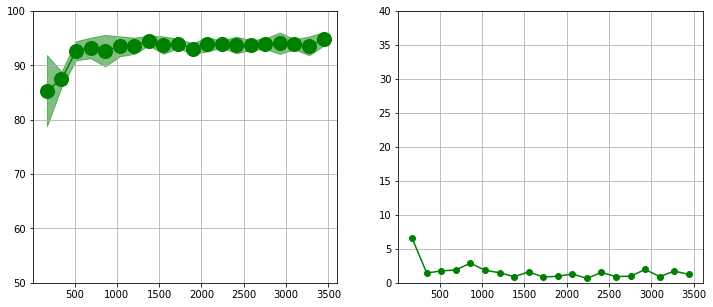

In [ ]:
import matplotlib.pyplot as plt

n = np.linspace(.05, 1.0, 20)

X_train_val= pd.DataFrame(df.iloc[:, 1:].values)  
train_sizes =  X_train_val.shape[0]* n
print(train_sizes)
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)

_, axes = plt.subplots(1, 2, figsize=(12, 5))


# Plot the learning curve for the deep one class network (TPR versus training dataset size)
axes[0].grid()
axes[0].fill_between(train_sizes, 
                    test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.5,
                         color="g")

axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", markersize=14,
                 label="Cross-validation score")

axes[0].set_ylim(50, 100)

# Plot showing the 
axes[1].grid()
axes[1].plot(train_sizes,test_scores_std, 'o-', color="g",
                 label="Cross-validation score")
axes[1].set_ylim(0, 40) 


In [ ]:
# Save the evaluation results for comparison with the standrard models 60=60 all the dataset
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc 

array([85.33896446, 87.42713572, 92.68298343, 93.20611267, 92.7105765 ,
       93.49630405, 93.61224559, 94.54100145, 93.72797617, 94.01850508,
       93.08907416, 93.84433962, 93.90214163, 93.75704594, 93.72793398,
       93.98956189, 94.07605394, 93.87324063, 93.58330239, 94.86064232])

In [ ]:
#final
deep_svdd_std

array([6.54267383, 1.44110274, 1.74769711, 1.8918508 , 2.8916519 ,
       1.84260101, 1.48514791, 0.88968012, 1.605241  , 0.85379602,
       0.96398815, 1.29698076, 0.65231736, 1.53146473, 0.90822596,
       0.98256344, 1.96132296, 0.9209378 , 1.72722318, 1.24033269])

In [ ]:
# Save the evaluation results for comparison with the standrard models 60=100
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc 

array([89.57753907, 90.21458467, 93.69953927, 92.94423161, 93.35019577,
       93.81543862, 93.90231039, 93.87345158, 93.6411044 , 94.27979546,
       94.07630708, 94.16355858, 94.07668681, 93.72772302, 93.81560739,
       94.25076788, 93.64127316, 94.27987984, 93.96066088, 94.42489115])

In [ ]:
deepsvdd_acc = np.array([86.44175921, 90.06885611, 91.26059   , 93.64139974, 93.06004658,
       93.43829109, 93.37922334, 93.96044993, 93.26294427, 94.65732271,
       93.75713032, 93.37901239, 93.5832602 , 93.96028116, 93.75700375,
       94.30886522, 94.10563   , 94.3089918 , 93.87281871, 94.27962669])
deep_svdd_std = np.array([5.4950041 , 2.54900057, 2.27762141, 2.07305564, 1.56067457,
       1.61848493, 2.23861163, 1.49904053, 1.75640443, 1.35986527,
       0.72395944, 1.4406427 , 0.92755038, 1.18967304, 1.68116874,
       1.64591397, 1.15996663, 0.76434046, 1.77407158, 1.53061797])

### Calculate k-fold cross validation for the deep network

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from random import Random

# Perform k-fold cross validation
import random
X_train_val=pd.DataFrame(labelled.iloc[:, :].values)
kf_score=[]
kf = KFold(n_splits = 5,  shuffle=True, random_state=0)
kf.get_n_splits(X_train_val)
scores2=[]
for train, test in kf.split(X_train_val):
  dataset = Pairs_Dataset('', train, test)  
  Random(0).shuffle(train)
  deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], 1e-5)
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  pretrain(deep_SVDD, dataset, n_epochs=100)
  pred_train = deep_SVDD.train(dataset,n_epochs=100)
  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  scores2.append(scores1)
  score_mean = np.mean(scores2)
kf_score.append(scores2)
scores2

In [ ]:
# Print Deep Neural Network kfold Accuracy
print(np.mean(scores2, 0))
print(np.std(scores2, 0))
scores2

94.36737445230872
0.745873116098849


[93.6231884057971,
 94.4927536231884,
 93.6046511627907,
 95.63953488372093,
 94.47674418604652]

In [225]:
deep_kfold = [0.936231884057971, 0.944927536231884, 0.936046511627907,
 0.9563953488372093, 0.9447674418604652]

# Learning curves comparison

In [398]:
deepsvdd_acc = np.array([81.1892484 , 91.75581395, 91.93023256, 93.03454668, 93.26373441,
       93.61223458, 93.03252444, 93.73003033, 93.43950118, 93.38136164,
       92.85776879, 93.32339063, 93.55443209, 93.84563532, 92.91691945,
       93.206606  , 93.09100101, 93.26457701, 93.67290192, 93.78682171])

deep_svdd_std = np.array([5.4950041 , 2.54900057, 2.27762141, 2.07305564, 1.56067457,
       1.61848493, 2.23861163, 1.49904053, 1.75640443, 1.35986527,
       0.72395944, 1.4406427 , 0.92755038, 1.18967304, 1.68116874,
       1.64591397, 1.15996663, 0.76434046, 1.77407158, 1.53061797])

In [399]:
# Combine all the accuracy scores 
accuracy.append(test_scores_mean_ens)
accuracy.append(deepsvdd_acc)
std.append(test_scores_std_ens)
std.append(deep_svdd_std)

In [400]:
train_sizes=train_sizes*2

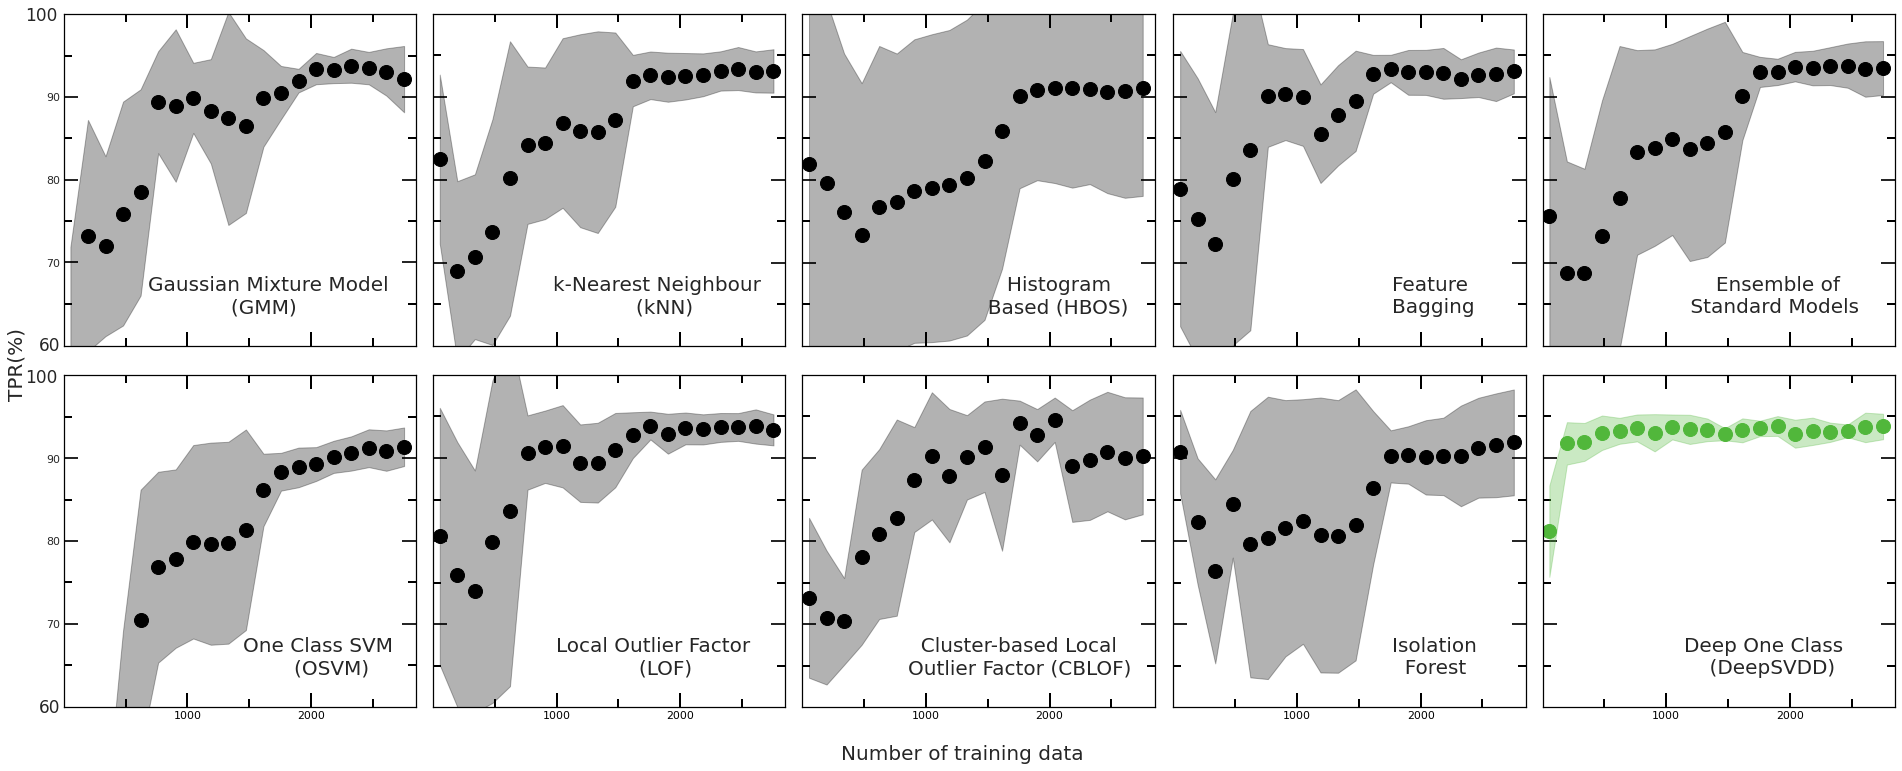

In [401]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
from matplotlib import rcParams
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(26,10),nrows=2, ncols=5,constrained_layout=True, gridspec_kw = {'wspace':0.25, 'hspace':0.25})

ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

colors = ['red', 'tan']
ax0.plot(train_sizes,accuracy[0], 'o', color="black", markersize=14, label= 'Gaussiann Mixture Model (GMM)' )
ax0.fill_between(train_sizes,accuracy[0] - std[0],  accuracy[0] + std[0], alpha=0.3,  color="black")
ax0.set_ylim(59.9, 100.1)
ax0.set_xlim(130, 2850)
ax0.text(0.24, 0.1, 'Gaussian Mixture Model\n             (GMM)', transform=ax0.transAxes,fontsize=20)
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100.1, 10)
minor_ticks_y = np.arange(60, 100.1, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
#ax0.set_yticklabels([]) 
ax0.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[-1].draw = lambda *args:None
#ax0.yaxis.majorTicks[0].tick1line.set_markersize(0)
#ax0.yaxis.majorTicks[-1].tick1line.set_markersize(0)
ax0.text(-0.0712, -0.015, '60', transform=ax0.transAxes, fontsize= 17)
ax0.text(-0.11, 0.978, '100', transform=ax0.transAxes, fontsize= 17)

# kNN
ax1.plot(train_sizes, accuracy[1], 'o', color="black", markersize=14, label= 'K Nearest Neighbors (KNN)' )
ax1.fill_between(train_sizes,accuracy[1] - std[1],  accuracy[1] + std[1], alpha=0.3,  color="black")
ax1.set_ylim(60, 100)
ax1.set_xlim(130, 2850)
ax1.text(0.34, 0.1, 'k-Nearest Neighbour\n             (kNN)', transform=ax1.transAxes,fontsize=20)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.yaxis.get_major_ticks()[0].draw = lambda *args:None

# HBOS 
ax2.plot(train_sizes, accuracy[2], 'o', color="black",markersize=14, label= 'Histogram-base Outlier Detection (HBOS)' )
ax2.fill_between(train_sizes, accuracy[2] - std[2],  accuracy[2] + std[2], alpha=0.3,  color="black")
ax2.set_ylim(60, 100)
#ax2.set_title('Histogram Based (HBOS)', fontsize=20, y=1.02)  #fontweight='bold', 
ax2.set_xlim(130, 2850)
ax2.text(0.49, 0.1, '     Histogram\n  Based (HBOS)', transform=ax2.transAxes,fontsize=20)
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis='x', colors='black')
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax2.yaxis.get_major_ticks()[0].draw = lambda *args:None

# Feature Bagging
ax3.plot(train_sizes,accuracy[3], 'o', color="black", markersize=14, label= 'Feature Bagging' )
ax3.fill_between(train_sizes, accuracy[3] - std[3],  accuracy[3] + std[3], alpha=0.3,  color="black")
ax3.set_ylim(60, 100)
ax3.set_xlim(130, 2850)
ax3.text(0.62, 0.1, 'Feature\nBagging', transform=ax3.transAxes,fontsize=20)
ax3.spines['bottom'].set_color('black')
ax3.spines['top'].set_color('black')
ax3.spines['right'].set_color('black')
ax3.spines['left'].set_color('black')
ax3.tick_params(axis = 'both', which='both', width=2)
ax3.tick_params(axis='x', colors='black')
ax3.tick_params(axis = 'both', which='major', length=14)
ax3.tick_params(axis = 'both', which='minor', length=8, color='black')
ax3.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax3.set_xticks(major_ticks_x)
ax3.set_xticks(minor_ticks_x, minor=True)
ax3.set_yticks(major_ticks_y)
ax3.set_yticks(minor_ticks_y, minor=True)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax3.yaxis.get_major_ticks()[0].draw = lambda *args:None

# Isolation Forest
ax8.plot(train_sizes,accuracy[4], 'o', color="black",markersize=14, label= 'Isolation Forest' )
ax8.fill_between(train_sizes,accuracy[4] - std[4],  accuracy[4] + std[4], alpha=0.3,  color="black")
ax8.set_ylim(60, 100)
ax8.set_xlim(130, 2850)
ax8.text(0.62, 0.1, 'Isolation\n  Forest', transform=ax8.transAxes,fontsize=20)
ax8.spines['bottom'].set_color('black')
ax8.spines['top'].set_color('black')
ax8.spines['right'].set_color('black')
ax8.spines['left'].set_color('black')
ax8.tick_params(axis = 'both', which='both', width=2)
ax8.tick_params(axis='x', colors='black')
ax8.tick_params(axis = 'both', which='major', length=14)
ax8.tick_params(axis = 'both', which='minor', length=8, color='black')
ax8.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax8.set_xticks(major_ticks_x)
ax8.set_xticks(minor_ticks_x, minor=True)
ax8.set_yticks(major_ticks_y)
ax8.set_yticks(minor_ticks_y, minor=True)
ax8.set_yticklabels([])
#ax8.set_xticklabels([])  #
ax8.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax8.yaxis.get_major_ticks()[0].draw = lambda *args:None

# OCSVM
ax5.plot(train_sizes, accuracy[5], 'o', color="black", markersize= 14, label= 'One class SVM (OCSVM)' )
ax5.fill_between(train_sizes, accuracy[5]- std[5],  accuracy[5] + std[5], alpha=0.3,  color="black")
ax5.set_ylim(59.9, 100.1)
ax5.set_xlim(130, 2850)
ax5.text(0.51, 0.1, 'One Class SVM\n        (OSVM)', transform=ax5.transAxes,fontsize=20)
ax5.spines['bottom'].set_color('black')
ax5.spines['top'].set_color('black')
ax5.spines['right'].set_color('black')
ax5.spines['left'].set_color('black')
ax5.tick_params(axis = 'both', which='both', width=2)
ax5.tick_params(axis='x', colors='black')
ax5.tick_params(axis = 'both', which='major', length=14)
ax5.tick_params(axis = 'both', which='minor', length=8, color='black')
ax5.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100.1, 10)
minor_ticks_y = np.arange(60, 100.1, 5)
ax5.set_xticks(major_ticks_x)
ax5.set_xticks(minor_ticks_x, minor=True)
ax5.set_yticks(major_ticks_y)
ax5.set_yticks(minor_ticks_y, minor=True)
ax5.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax5.yaxis.get_major_ticks()[0].draw = lambda *args:None
#ax5.set_xticklabels([])
#ax5.set_yticklabels([])
#ax5.yaxis.majorTicks[0].tick1line.set_markersize(0)
#ax5.yaxis.majorTicks[-1].tick1line.set_markersize(0)
ax5.yaxis.get_major_ticks()[-1].draw = lambda *args:None
ax5.text(-0.0712, -0.015, '60', transform=ax5.transAxes, fontsize= 17)
ax5.text(-0.11, 0.978, '100', transform=ax5.transAxes, fontsize= 17)

# LOF
ax6.plot(train_sizes, accuracy[6], 'o', color="black", markersize=14,label= 'Local Outlier Factor (LOF)' )
ax6.fill_between(train_sizes,accuracy[6] - std[6],  accuracy[6] + std[6], alpha=0.3,  color="black")
ax6.set_ylim(60, 100)
ax6.set_xlim(130, 2850)
ax6.text(0.35, 0.1, 'Local Outlier Factor\n             (LOF)', transform=ax6.transAxes,fontsize=20)
ax6.spines['bottom'].set_color('black')
ax6.spines['top'].set_color('black')
ax6.spines['right'].set_color('black')
ax6.spines['left'].set_color('black')
ax6.tick_params(axis = 'both', which='both', width=2)
ax6.tick_params(axis='x', colors='black')
ax6.tick_params(axis = 'both', which='major', length=14)
ax6.tick_params(axis = 'both', which='minor', length=8, color='black')
ax6.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax6.set_xticks(major_ticks_x)
ax6.set_xticks(minor_ticks_x, minor=True)
ax6.set_yticks(major_ticks_y)
ax6.set_yticks(minor_ticks_y, minor=True)
ax6.set_yticklabels([])
#ax6.set_xticklabels([])
ax6.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax6.yaxis.get_major_ticks()[0].draw = lambda *args:None

# CBLOF
ax7.plot(train_sizes, accuracy[7], 'o', color="black",markersize= 14, label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax7.fill_between(train_sizes,accuracy[7] - std[7], accuracy[7] + std[7], alpha=0.3,  color="black")
ax7.set_ylim(60, 100)
ax7.set_xlim(130, 2850)
ax7.text(0.3, 0.1, '  Cluster-based Local\nOutlier Factor (CBLOF)', transform=ax7.transAxes,fontsize=20)
ax7.spines['bottom'].set_color('black')
ax7.spines['top'].set_color('black')
ax7.spines['right'].set_color('black')
ax7.spines['left'].set_color('black')
ax7.tick_params(axis = 'both', which='both', width=2)
ax7.tick_params(axis='x', colors='black')
ax7.tick_params(axis = 'both', which='major', length=14)
ax7.tick_params(axis = 'both', which='minor', length=8, color='black')
ax7.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax7.set_xticks(major_ticks_x)
ax7.set_xticks(minor_ticks_x, minor=True)
ax7.set_yticks(major_ticks_y)
ax7.set_yticks(minor_ticks_y, minor=True)
ax7.set_yticklabels([])
#ax7.set_xticklabels([])
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None

# DeepSVDD
ax9.plot(train_sizes, accuracy[9], 'o', color="#51b73b",markersize =14, label= 'DeepSVDD')
ax9.fill_between(train_sizes, accuracy[9] - std[9],  accuracy[9] + std[9], alpha=0.3,  color='#51b73b')   #'#028f1e')
ax9.set_ylim(60, 100)
ax9.set_xlim(130, 2850)
ax9.text(0.4, 0.1, 'Deep One Class\n    (DeepSVDD)', transform=ax9.transAxes,fontsize=20)
ax9.spines['bottom'].set_color('black')
ax9.spines['top'].set_color('black')
ax9.spines['right'].set_color('black')
ax9.spines['left'].set_color('black')
ax9.tick_params(axis = 'both', which='both', width=2)
ax9.tick_params(axis='x', colors='black')
ax9.tick_params(axis = 'both', which='major', length=14)
ax9.tick_params(axis = 'both', which='minor', length=8, color='black')
ax9.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax9.set_xticks(major_ticks_x)
ax9.set_xticks(minor_ticks_x, minor=True)
ax9.set_yticks(major_ticks_y)
ax9.set_yticks(minor_ticks_y, minor=True)
ax9.set_yticklabels([])
#ax9.set_xticklabels([])
ax9.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax9.yaxis.get_major_ticks()[0].draw = lambda *args:None


# Ensemble
ax4.plot(train_sizes, accuracy[8], 'o', markersize=14, color="black", label='Ensemble') 
ax4.fill_between(train_sizes, accuracy[8] - std[8],  accuracy[8] + std[8], alpha=0.3,  color="black")
ax4.set_ylim(60, 100)
ax4.set_xlim(130, 2850)
ax4.text(0.4, 0.1, '     Ensemble of\n Standard Models', transform=ax4.transAxes,fontsize=20)
ax4.spines['bottom'].set_color('black')
ax4.spines['top'].set_color('black')
ax4.spines['right'].set_color('black')
ax4.spines['left'].set_color('black')
ax4.tick_params(axis = 'both', which='both', width=2)
ax4.tick_params(axis='x', colors='black')
ax4.tick_params(axis = 'both', which='major', length=14)
ax4.tick_params(axis = 'both', which='minor', length=8, color='black')
ax4.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax4.set_xticks(major_ticks_x)
ax4.set_xticks(minor_ticks_x, minor=True)
ax4.set_yticks(major_ticks_y)
ax4.set_yticks(minor_ticks_y, minor=True)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax4.yaxis.get_major_ticks()[0].draw = lambda *args:None


import matplotlib.font_manager
rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False
rcParams['patch.edgecolor'] = 'black'


#fig.tight_layout()
fig.text(0.5, -0.05, 'Number of training data', ha='center',fontsize=20 )
fig.text(-0.01, 0.5, 'TPR(%)', va='center', rotation='vertical', fontsize=20)

#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/figure4_new.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


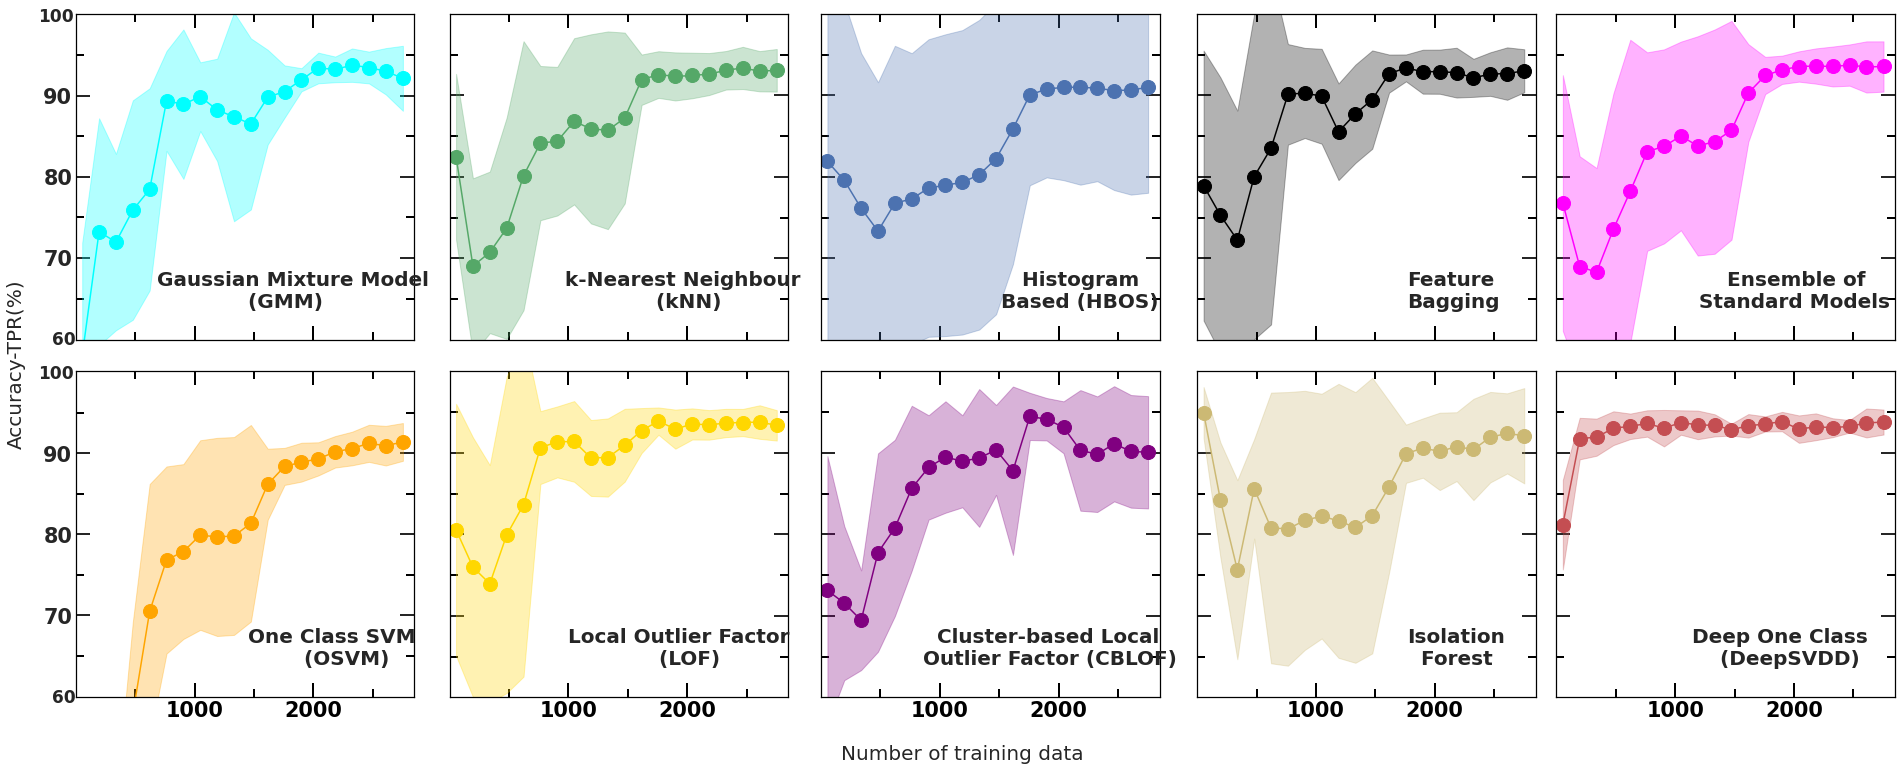

In [292]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
from matplotlib import rcParams
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(26,10),nrows=2, ncols=5,constrained_layout=True, gridspec_kw = {'wspace':0.25, 'hspace':0.25})

ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

colors = ['red', 'tan']
ax0.plot(train_sizes,accuracy[0], 'o-', color="cyan", markersize=14, label= 'Gaussiann Mixture Model (GMM)' )
ax0.fill_between(train_sizes,accuracy[0] - std[0],  accuracy[0] + std[0], alpha=0.3,  color="cyan")
ax0.set_ylim(59.9, 100.1)
#ax0.set_title('Gaussian Mixture Model (GMM)',  fontsize=20, y=1.02) #fontweight='bold',
ax0.set_xlim(130, 2850)
ax0.text(0.24, 0.1, 'Gaussian Mixture Model\n             (GMM)', transform=ax0.transAxes,fontsize=20)
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100.1, 10)
minor_ticks_y = np.arange(60, 100.1, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
#ax0.set_yticklabels([]) 
ax0.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[-1].draw = lambda *args:None
#ax0.yaxis.majorTicks[0].tick1line.set_markersize(0)
#ax0.yaxis.majorTicks[-1].tick1line.set_markersize(0)
ax0.text(-0.0712, -0.015, '60', transform=ax0.transAxes, fontsize= 17)
ax0.text(-0.11, 0.978, '100', transform=ax0.transAxes, fontsize= 17)

# kNN
ax1.plot(train_sizes, accuracy[1], 'o-', color="g", markersize=14, label= 'K Nearest Neighbors (KNN)' )
ax1.fill_between(train_sizes,accuracy[1] - std[1],  accuracy[1] + std[1], alpha=0.3,  color="g")
ax1.set_ylim(60, 100)
#ax1.set_title('k-Nearest Neighbour  (kNN)',  fontsize=20, y=1.02)  # fontweight='bold',
ax1.set_xlim(130, 2850)
ax1.text(0.34, 0.1, 'k-Nearest Neighbour\n             (kNN)', transform=ax1.transAxes,fontsize=20)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.yaxis.get_major_ticks()[0].draw = lambda *args:None

# HBOS 
ax2.plot(train_sizes, accuracy[2], 'o-', color="b",markersize=14, label= 'Histogram-base Outlier Detection (HBOS)' )
ax2.fill_between(train_sizes, accuracy[2] - std[2],  accuracy[2] + std[2], alpha=0.3,  color="b")
ax2.set_ylim(60, 100)
#ax2.set_title('Histogram Based (HBOS)', fontsize=20, y=1.02)  #fontweight='bold', 
ax2.set_xlim(130, 2850)
ax2.text(0.49, 0.1, '     Histogram\n  Based (HBOS)', transform=ax2.transAxes,fontsize=20)
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis='x', colors='black')
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax2.yaxis.get_major_ticks()[0].draw = lambda *args:None

# Feature Bagging
ax3.plot(train_sizes,accuracy[3], 'o-', color="black", markersize=14, label= 'Feature Bagging' )
ax3.fill_between(train_sizes, accuracy[3] - std[3],  accuracy[3] + std[3], alpha=0.3,  color="black")
ax3.set_ylim(60, 100)
#ax3.set_title('Feature Bagging', fontsize=20, y=1.02)  # fontweight='bold',
ax3.set_xlim(130, 2850)
ax3.text(0.62, 0.1, 'Feature\nBagging', transform=ax3.transAxes,fontsize=20)
ax3.spines['bottom'].set_color('black')
ax3.spines['top'].set_color('black')
ax3.spines['right'].set_color('black')
ax3.spines['left'].set_color('black')
ax3.tick_params(axis = 'both', which='both', width=2)
ax3.tick_params(axis='x', colors='black')
ax3.tick_params(axis = 'both', which='major', length=14)
ax3.tick_params(axis = 'both', which='minor', length=8, color='black')
ax3.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax3.set_xticks(major_ticks_x)
ax3.set_xticks(minor_ticks_x, minor=True)
ax3.set_yticks(major_ticks_y)
ax3.set_yticks(minor_ticks_y, minor=True)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax3.yaxis.get_major_ticks()[0].draw = lambda *args:None

# Isolation Forest
ax8.plot(train_sizes,accuracy[4], 'o-', color="y",markersize=14, label= 'Isolation Forest' )
ax8.fill_between(train_sizes,accuracy[4] - std[4],  accuracy[4] + std[4], alpha=0.3,  color="y")
ax8.set_ylim(60, 100)
#ax8.set_title('Isolation Forest',  fontsize=20, y=1.02)  #fontweight='bold',
ax8.set_xlim(130, 2850)
ax8.text(0.62, 0.1, 'Isolation\n  Forest', transform=ax8.transAxes,fontsize=20)
ax8.spines['bottom'].set_color('black')
ax8.spines['top'].set_color('black')
ax8.spines['right'].set_color('black')
ax8.spines['left'].set_color('black')
ax8.tick_params(axis = 'both', which='both', width=2)
ax8.tick_params(axis='x', colors='black')
ax8.tick_params(axis = 'both', which='major', length=14)
ax8.tick_params(axis = 'both', which='minor', length=8, color='black')
ax8.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax8.set_xticks(major_ticks_x)
ax8.set_xticks(minor_ticks_x, minor=True)
ax8.set_yticks(major_ticks_y)
ax8.set_yticks(minor_ticks_y, minor=True)
ax8.set_yticklabels([])
#ax8.set_xticklabels([])  #
ax8.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax8.yaxis.get_major_ticks()[0].draw = lambda *args:None

# OCSVM
ax5.plot(train_sizes, accuracy[5], 'o-', color="orange", markersize= 14, label= 'One class SVM (OCSVM)' )
ax5.fill_between(train_sizes, accuracy[5]- std[5],  accuracy[5] + std[5], alpha=0.3,  color="orange")
ax5.set_ylim(59.9, 100.1)
#ax5.set_title('One Class SVM (OSVM)',fontsize=20, y=1.02) # fontweight='bold', 
ax5.set_xlim(130, 2850)
ax5.text(0.51, 0.1, 'One Class SVM\n        (OSVM)', transform=ax5.transAxes,fontsize=20)
ax5.spines['bottom'].set_color('black')
ax5.spines['top'].set_color('black')
ax5.spines['right'].set_color('black')
ax5.spines['left'].set_color('black')
ax5.tick_params(axis = 'both', which='both', width=2)
ax5.tick_params(axis='x', colors='black')
ax5.tick_params(axis = 'both', which='major', length=14)
ax5.tick_params(axis = 'both', which='minor', length=8, color='black')
ax5.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100.1, 10)
minor_ticks_y = np.arange(60, 100.1, 5)
ax5.set_xticks(major_ticks_x)
ax5.set_xticks(minor_ticks_x, minor=True)
ax5.set_yticks(major_ticks_y)
ax5.set_yticks(minor_ticks_y, minor=True)
ax5.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax5.yaxis.get_major_ticks()[0].draw = lambda *args:None
#ax5.set_xticklabels([])
#ax5.set_yticklabels([])
#ax5.yaxis.majorTicks[0].tick1line.set_markersize(0)
#ax5.yaxis.majorTicks[-1].tick1line.set_markersize(0)
ax5.yaxis.get_major_ticks()[-1].draw = lambda *args:None
ax5.text(-0.0712, -0.015, '60', transform=ax5.transAxes, fontsize= 17)
ax5.text(-0.11, 0.978, '100', transform=ax5.transAxes, fontsize= 17)

# LOF
ax6.plot(train_sizes, accuracy[6], 'o-', color="gold", markersize=14,label= 'Local Outlier Factor (LOF)' )
ax6.fill_between(train_sizes,accuracy[6] - std[6],  accuracy[6] + std[6], alpha=0.3,  color="gold")
ax6.set_ylim(60, 100)
#ax6.set_title('Local Outlier Factor (LOF)',fontsize=20, y=1.02) # fontweight='bold', 
ax6.set_xlim(130, 2850)
ax6.text(0.35, 0.1, 'Local Outlier Factor\n             (LOF)', transform=ax6.transAxes,fontsize=20)
ax6.spines['bottom'].set_color('black')
ax6.spines['top'].set_color('black')
ax6.spines['right'].set_color('black')
ax6.spines['left'].set_color('black')
ax6.tick_params(axis = 'both', which='both', width=2)
ax6.tick_params(axis='x', colors='black')
ax6.tick_params(axis = 'both', which='major', length=14)
ax6.tick_params(axis = 'both', which='minor', length=8, color='black')
ax6.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax6.set_xticks(major_ticks_x)
ax6.set_xticks(minor_ticks_x, minor=True)
ax6.set_yticks(major_ticks_y)
ax6.set_yticks(minor_ticks_y, minor=True)
ax6.set_yticklabels([])
#ax6.set_xticklabels([])
ax6.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax6.yaxis.get_major_ticks()[0].draw = lambda *args:None

# CBLOF
ax7.plot(train_sizes, accuracy[7], 'o-', color="purple",markersize= 14, label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax7.fill_between(train_sizes,accuracy[7] - std[7], accuracy[7] + std[7], alpha=0.3,  color="purple")
ax7.set_ylim(60, 100)
ax7.set_xlim(130, 2850)
ax7.text(0.3, 0.1, '  Cluster-based Local\nOutlier Factor (CBLOF)', transform=ax7.transAxes,fontsize=20)
ax7.spines['bottom'].set_color('black')
ax7.spines['top'].set_color('black')
ax7.spines['right'].set_color('black')
ax7.spines['left'].set_color('black')
ax7.tick_params(axis = 'both', which='both', width=2)
ax7.tick_params(axis='x', colors='black')
ax7.tick_params(axis = 'both', which='major', length=14)
ax7.tick_params(axis = 'both', which='minor', length=8, color='black')
ax7.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax7.set_xticks(major_ticks_x)
ax7.set_xticks(minor_ticks_x, minor=True)
ax7.set_yticks(major_ticks_y)
ax7.set_yticks(minor_ticks_y, minor=True)
ax7.set_yticklabels([])
#ax7.set_xticklabels([])
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None

# DeepSVDD
ax9.plot(train_sizes, accuracy[9], 'o-', color="r",markersize =14, label= 'DeepSVDD')
ax9.fill_between(train_sizes, accuracy[9] - std[9],  accuracy[9] + std[9], alpha=0.3,  color='r')
ax9.set_ylim(60, 100)
ax9.set_xlim(130, 2850)
#ax9.set_title('DeepSVDD', fontsize=20,  y=1.02) # fontweight='bold',
ax9.text(0.4, 0.1, 'Deep One Class\n    (DeepSVDD)', transform=ax9.transAxes,fontsize=20)
ax9.spines['bottom'].set_color('black')
ax9.spines['top'].set_color('black')
ax9.spines['right'].set_color('black')
ax9.spines['left'].set_color('black')
ax9.tick_params(axis = 'both', which='both', width=2)
ax9.tick_params(axis='x', colors='black')
ax9.tick_params(axis = 'both', which='major', length=14)
ax9.tick_params(axis = 'both', which='minor', length=8, color='black')
ax9.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax9.set_xticks(major_ticks_x)
ax9.set_xticks(minor_ticks_x, minor=True)
ax9.set_yticks(major_ticks_y)
ax9.set_yticks(minor_ticks_y, minor=True)
ax9.set_yticklabels([])
#ax9.set_xticklabels([])
ax9.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax9.yaxis.get_major_ticks()[0].draw = lambda *args:None


# Ensemble
ax4.plot(train_sizes, accuracy[8], 'o-', markersize=14, color="magenta", label='Ensemble') 
ax4.fill_between(train_sizes, accuracy[8] - std[8],  accuracy[8] + std[8], alpha=0.3,  color="magenta")
ax4.set_ylim(60, 100)
ax4.set_xlim(130, 2850)
#ax4.set_title('Ensemble of Standard Models',fontsize=20, y=1.02 ) # fontweight='bold', 
ax4.text(0.4, 0.1, '     Ensemble of\n Standard Models', transform=ax4.transAxes,fontsize=20)
ax4.spines['bottom'].set_color('black')
ax4.spines['top'].set_color('black')
ax4.spines['right'].set_color('black')
ax4.spines['left'].set_color('black')
ax4.tick_params(axis = 'both', which='both', width=2)
ax4.tick_params(axis='x', colors='black')
ax4.tick_params(axis = 'both', which='major', length=14)
ax4.tick_params(axis = 'both', which='minor', length=8, color='black')
ax4.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax4.set_xticks(major_ticks_x)
ax4.set_xticks(minor_ticks_x, minor=True)
ax4.set_yticks(major_ticks_y)
ax4.set_yticks(minor_ticks_y, minor=True)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax4.yaxis.get_major_ticks()[0].draw = lambda *args:None


import matplotlib.font_manager
rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False
rcParams['patch.edgecolor'] = 'black'


#fig.tight_layout()
fig.text(0.5, -0.05, 'Number of training data', ha='center',fontsize=20 )
fig.text(-0.01, 0.5, 'Accuracy-TPR(%)', va='center', rotation='vertical', fontsize=20)

#plt.savefig('figure4_new.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

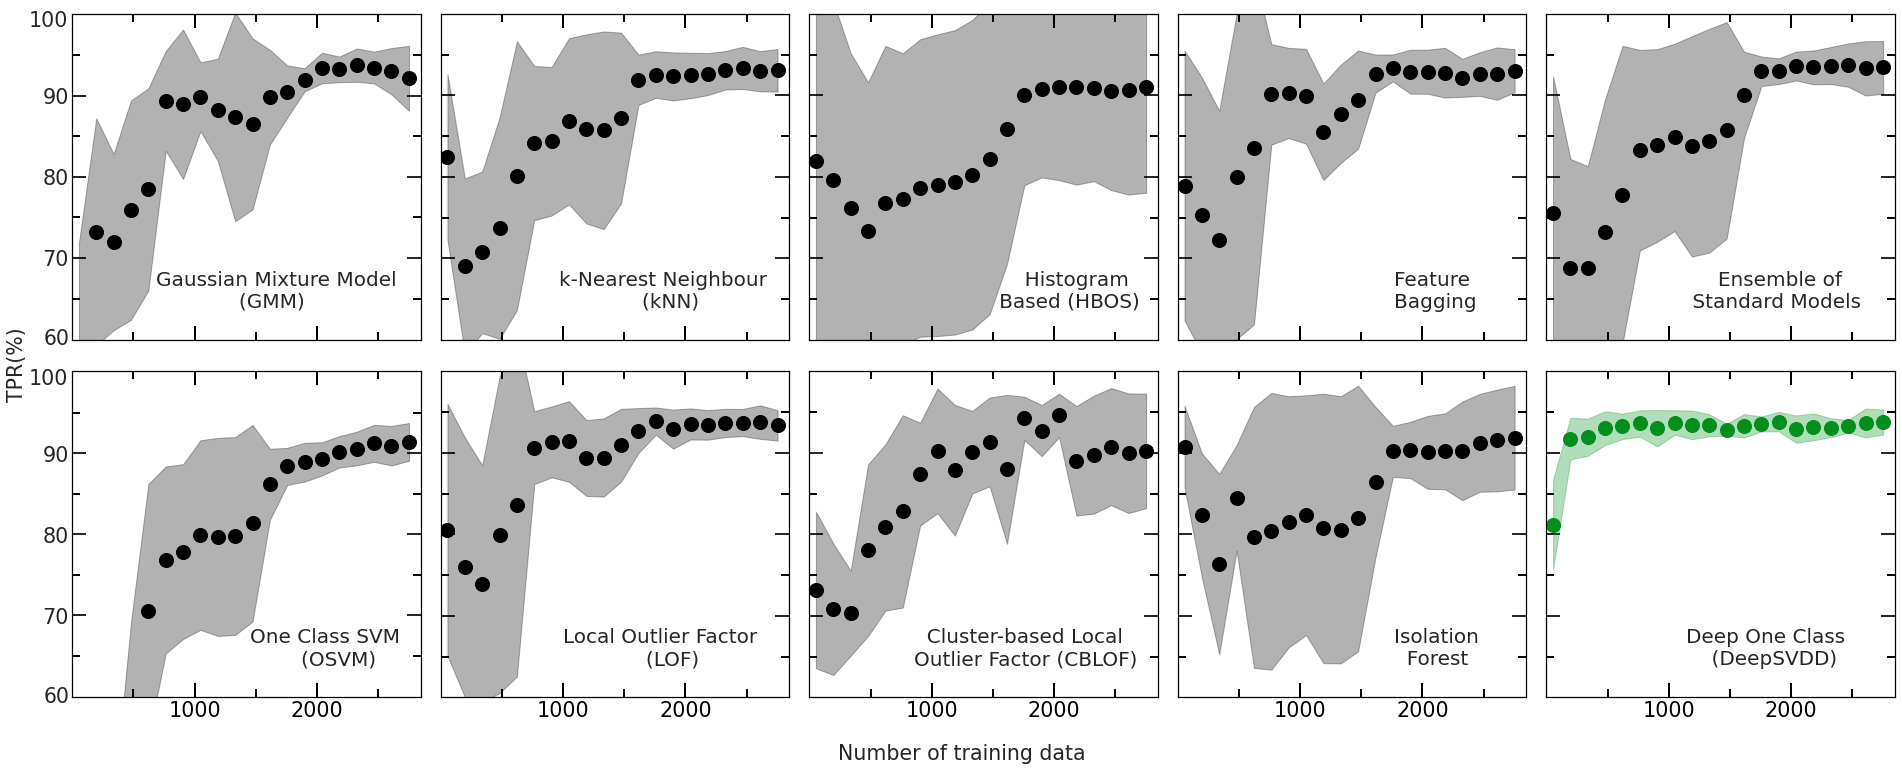

In [410]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.font_manager

plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False
rcParams['patch.edgecolor'] = 'black'


fig, axes = plt.subplots(figsize=(26,10),nrows=2, ncols=5,constrained_layout=True, gridspec_kw = {'wspace':0.25, 'hspace':0.25})

ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

colors = ['red', 'tan']
ax0.plot(train_sizes,accuracy[0], 'o', color="black", markersize=14, label= 'Gaussiann Mixture Model (GMM)' )
ax0.fill_between(train_sizes,accuracy[0] - std[0],  accuracy[0] + std[0], alpha=0.3,  color="black")
ax0.set_ylim(59.9, 100.1)
#ax0.set_title('Gaussian Mixture Model (GMM)',  fontsize=20, y=1.02) #fontweight='bold',
ax0.set_xlim(130, 2850)
ax0.text(0.24, 0.1, 'Gaussian Mixture Model\n             (GMM)', transform=ax0.transAxes,fontsize=20)
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100.1, 10)
minor_ticks_y = np.arange(60, 100.1, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
#ax0.set_yticklabels([]) 
ax0.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[-1].draw = lambda *args:None
#ax0.yaxis.majorTicks[0].tick1line.set_markersize(0)
#ax0.yaxis.majorTicks[-1].tick1line.set_markersize(0)
ax0.text(-0.0818, -0.015, '60', transform=ax0.transAxes, fontsize= 20.5)
ax0.text(-0.1245, 0.96, '100', transform=ax0.transAxes, fontsize= 20.5)

# kNN
ax1.plot(train_sizes, accuracy[1], 'o', color="black", markersize=14, label= 'K Nearest Neighbors (KNN)' )
ax1.fill_between(train_sizes,accuracy[1] - std[1],  accuracy[1] + std[1], alpha=0.3,  color="black")
ax1.set_ylim(60, 100)
#ax1.set_title('k-Nearest Neighbour  (kNN)',  fontsize=20, y=1.02)  # fontweight='bold',
ax1.set_xlim(130, 2850)
ax1.text(0.34, 0.1, 'k-Nearest Neighbour\n             (kNN)', transform=ax1.transAxes,fontsize=20)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.yaxis.get_major_ticks()[0].draw = lambda *args:None

# HBOS 
ax2.plot(train_sizes, accuracy[2], 'o', color="black",markersize=14, label= 'Histogram-base Outlier Detection (HBOS)' )
ax2.fill_between(train_sizes, accuracy[2] - std[2],  accuracy[2] + std[2], alpha=0.3,  color="black")
ax2.set_ylim(60, 100)
#ax2.set_title('Histogram Based (HBOS)', fontsize=20, y=1.02)  #fontweight='bold', 
ax2.set_xlim(130, 2850)
ax2.text(0.49, 0.1, '       Histogram\n   Based (HBOS)', transform=ax2.transAxes,fontsize=20)
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis='x', colors='black')
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax2.yaxis.get_major_ticks()[0].draw = lambda *args:None

# Feature Bagging
ax3.plot(train_sizes,accuracy[3], 'o', color="black", markersize=14, label= 'Feature Bagging' )
ax3.fill_between(train_sizes, accuracy[3] - std[3],  accuracy[3] + std[3], alpha=0.3,  color="black")
ax3.set_ylim(60, 100)
#ax3.set_title('Feature Bagging', fontsize=20, y=1.02)  # fontweight='bold',
ax3.set_xlim(130, 2850)
ax3.text(0.62, 0.1, 'Feature\nBagging', transform=ax3.transAxes,fontsize=20)
ax3.spines['bottom'].set_color('black')
ax3.spines['top'].set_color('black')
ax3.spines['right'].set_color('black')
ax3.spines['left'].set_color('black')
ax3.tick_params(axis = 'both', which='both', width=2)
ax3.tick_params(axis='x', colors='black')
ax3.tick_params(axis = 'both', which='major', length=14)
ax3.tick_params(axis = 'both', which='minor', length=8, color='black')
ax3.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax3.set_xticks(major_ticks_x)
ax3.set_xticks(minor_ticks_x, minor=True)
ax3.set_yticks(major_ticks_y)
ax3.set_yticks(minor_ticks_y, minor=True)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax3.yaxis.get_major_ticks()[0].draw = lambda *args:None

# Isolation Forest
ax8.plot(train_sizes,accuracy[4], 'o', color="black",markersize=14, label= 'Isolation Forest' )
ax8.fill_between(train_sizes,accuracy[4] - std[4],  accuracy[4] + std[4], alpha=0.3,  color="black")
ax8.set_ylim(60, 100)
#ax8.set_title('Isolation Forest',  fontsize=20, y=1.02)  #fontweight='bold',
ax8.set_xlim(130, 2850)
ax8.text(0.62, 0.1, 'Isolation\n  Forest', transform=ax8.transAxes,fontsize=20)
ax8.spines['bottom'].set_color('black')
ax8.spines['top'].set_color('black')
ax8.spines['right'].set_color('black')
ax8.spines['left'].set_color('black')
ax8.tick_params(axis = 'both', which='both', width=2)
ax8.tick_params(axis='x', colors='black')
ax8.tick_params(axis = 'both', which='major', length=14)
ax8.tick_params(axis = 'both', which='minor', length=8, color='black')
ax8.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax8.set_xticks(major_ticks_x)
ax8.set_xticks(minor_ticks_x, minor=True)
ax8.set_yticks(major_ticks_y)
ax8.set_yticks(minor_ticks_y, minor=True)
ax8.set_yticklabels([])
#ax8.set_xticklabels([])  #
ax8.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax8.yaxis.get_major_ticks()[0].draw = lambda *args:None

# OCSVM
ax5.plot(train_sizes, accuracy[5], 'o', color="black", markersize= 14, label= 'One class SVM (OCSVM)' )
ax5.fill_between(train_sizes, accuracy[5]- std[5],  accuracy[5] + std[5], alpha=0.3,  color="black")
ax5.set_ylim(59.9, 100.1)
#ax5.set_title('One Class SVM (OSVM)',fontsize=20, y=1.02) # fontweight='bold', 
ax5.set_xlim(130, 2850)
ax5.text(0.51, 0.1, 'One Class SVM\n        (OSVM)', transform=ax5.transAxes,fontsize=20)
ax5.spines['bottom'].set_color('black')
ax5.spines['top'].set_color('black')
ax5.spines['right'].set_color('black')
ax5.spines['left'].set_color('black')
ax5.tick_params(axis = 'both', which='both', width=2)
ax5.tick_params(axis='x', colors='black')
ax5.tick_params(axis = 'both', which='major', length=14)
ax5.tick_params(axis = 'both', which='minor', length=8, color='black')
ax5.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100.1, 10)
minor_ticks_y = np.arange(60, 100.1, 5)
ax5.set_xticks(major_ticks_x)
ax5.set_xticks(minor_ticks_x, minor=True)
ax5.set_yticks(major_ticks_y)
ax5.set_yticks(minor_ticks_y, minor=True)
ax5.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax5.yaxis.get_major_ticks()[0].draw = lambda *args:None
#ax5.set_xticklabels([])
#ax5.set_yticklabels([])
#ax5.yaxis.majorTicks[0].tick1line.set_markersize(0)
#ax5.yaxis.majorTicks[-1].tick1line.set_markersize(0)
ax5.yaxis.get_major_ticks()[-1].draw = lambda *args:None
ax5.text(-0.0818, -0.015, '60', transform=ax5.transAxes, fontsize= 20.5)
ax5.text(-0.1245, 0.96, '100', transform=ax5.transAxes, fontsize= 20.5)

# LOF
ax6.plot(train_sizes, accuracy[6], 'o', color="black", markersize=14,label= 'Local Outlier Factor (LOF)' )
ax6.fill_between(train_sizes,accuracy[6] - std[6],  accuracy[6] + std[6], alpha=0.3,  color="black")
ax6.set_ylim(60, 100)
#ax6.set_title('Local Outlier Factor (LOF)',fontsize=20, y=1.02) # fontweight='bold', 
ax6.set_xlim(130, 2850)
ax6.text(0.35, 0.1, 'Local Outlier Factor\n             (LOF)', transform=ax6.transAxes,fontsize=20)
ax6.spines['bottom'].set_color('black')
ax6.spines['top'].set_color('black')
ax6.spines['right'].set_color('black')
ax6.spines['left'].set_color('black')
ax6.tick_params(axis = 'both', which='both', width=2)
ax6.tick_params(axis='x', colors='black')
ax6.tick_params(axis = 'both', which='major', length=14)
ax6.tick_params(axis = 'both', which='minor', length=8, color='black')
ax6.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax6.set_xticks(major_ticks_x)
ax6.set_xticks(minor_ticks_x, minor=True)
ax6.set_yticks(major_ticks_y)
ax6.set_yticks(minor_ticks_y, minor=True)
ax6.set_yticklabels([])
#ax6.set_xticklabels([])
ax6.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax6.yaxis.get_major_ticks()[0].draw = lambda *args:None

# CBLOF
ax7.plot(train_sizes, accuracy[7], 'o', color="black",markersize= 14, label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax7.fill_between(train_sizes,accuracy[7] - std[7], accuracy[7] + std[7], alpha=0.3,  color="black")
ax7.set_ylim(60, 100)
ax7.set_xlim(130, 2850)
ax7.text(0.3, 0.1, '  Cluster-based Local\nOutlier Factor (CBLOF)', transform=ax7.transAxes,fontsize=20)
ax7.spines['bottom'].set_color('black')
ax7.spines['top'].set_color('black')
ax7.spines['right'].set_color('black')
ax7.spines['left'].set_color('black')
ax7.tick_params(axis = 'both', which='both', width=2)
ax7.tick_params(axis='x', colors='black')
ax7.tick_params(axis = 'both', which='major', length=14)
ax7.tick_params(axis = 'both', which='minor', length=8, color='black')
ax7.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax7.set_xticks(major_ticks_x)
ax7.set_xticks(minor_ticks_x, minor=True)
ax7.set_yticks(major_ticks_y)
ax7.set_yticks(minor_ticks_y, minor=True)
ax7.set_yticklabels([])
#ax7.set_xticklabels([])
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None

# DeepSVDD
ax9.plot(train_sizes, accuracy[9], 'o', color="#028f1e",markersize =14, label= 'DeepSVDD')
ax9.fill_between(train_sizes, accuracy[9] - std[9],  accuracy[9] + std[9], alpha=0.3,  color='#028f1e')
ax9.set_ylim(60, 100)
ax9.set_xlim(130, 2850)
#ax9.set_title('DeepSVDD', fontsize=20,  y=1.02) # fontweight='bold',
ax9.text(0.4, 0.1, 'Deep One Class\n    (DeepSVDD)', transform=ax9.transAxes,fontsize=20)
ax9.spines['bottom'].set_color('black')
ax9.spines['top'].set_color('black')
ax9.spines['right'].set_color('black')
ax9.spines['left'].set_color('black')
ax9.tick_params(axis = 'both', which='both', width=2)
ax9.tick_params(axis='x', colors='black')
ax9.tick_params(axis = 'both', which='major', length=14)
ax9.tick_params(axis = 'both', which='minor', length=8, color='black')
ax9.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax9.set_xticks(major_ticks_x)
ax9.set_xticks(minor_ticks_x, minor=True)
ax9.set_yticks(major_ticks_y)
ax9.set_yticks(minor_ticks_y, minor=True)
ax9.set_yticklabels([])
#ax9.set_xticklabels([])
ax9.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax9.yaxis.get_major_ticks()[0].draw = lambda *args:None


# Ensemble
ax4.plot(train_sizes, accuracy[8], 'o', markersize=14, color="black", label='Ensemble') 
ax4.fill_between(train_sizes, accuracy[8] - std[8],  accuracy[8] + std[8], alpha=0.3,  color="black")
ax4.set_ylim(60, 100)
ax4.set_xlim(130, 2850)
#ax4.set_title('Ensemble of Standard Models',fontsize=20, y=1.02 ) # fontweight='bold', 
ax4.text(0.4, 0.1, '     Ensemble of\n Standard Models', transform=ax4.transAxes,fontsize=20)
ax4.spines['bottom'].set_color('black')
ax4.spines['top'].set_color('black')
ax4.spines['right'].set_color('black')
ax4.spines['left'].set_color('black')
ax4.tick_params(axis = 'both', which='both', width=2)
ax4.tick_params(axis='x', colors='black')
ax4.tick_params(axis = 'both', which='major', length=14)
ax4.tick_params(axis = 'both', which='minor', length=8, color='black')
ax4.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax4.set_xticks(major_ticks_x)
ax4.set_xticks(minor_ticks_x, minor=True)
ax4.set_yticks(major_ticks_y)
ax4.set_yticks(minor_ticks_y, minor=True)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax4.yaxis.get_major_ticks()[0].draw = lambda *args:None



#fig.tight_layout()
fig.text(0.5, -0.05, 'Number of training data', ha='center',fontsize=20.5 )
fig.text(-0.01, 0.5, 'TPR(%)', va='center', rotation='vertical', fontsize=20.5)

#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/learning_curves_main.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

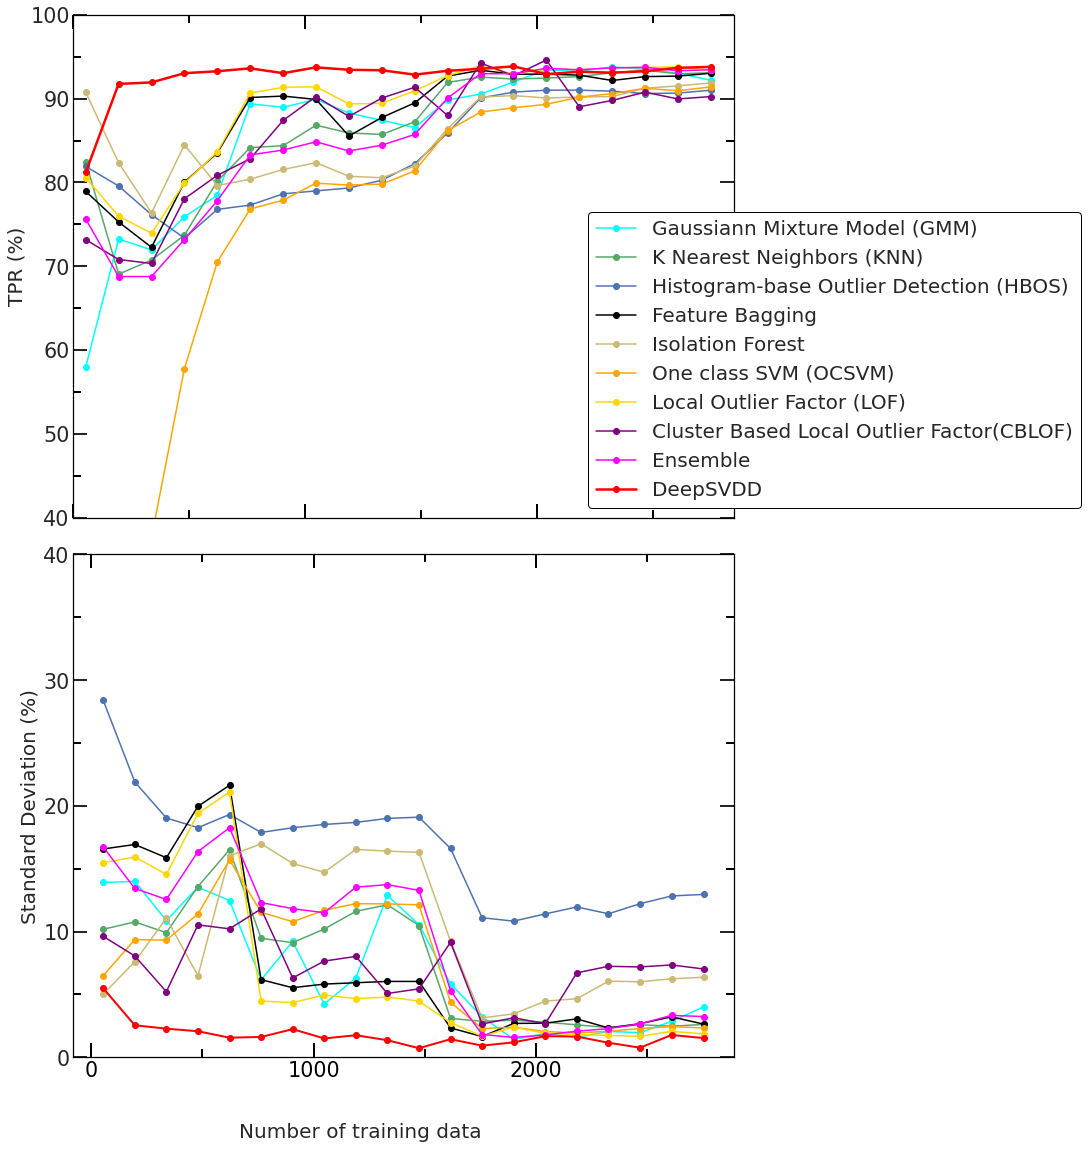

In [412]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
fig, axes = plt.subplots(figsize=(15,15),nrows=2, ncols=1,constrained_layout=True, gridspec_kw = {'wspace':0.25, 'hspace':0.25})

ax0, ax1= axes.flatten()


ax0.plot(train_sizes,accuracy[0], 'o-', color="cyan", label= 'Gaussiann Mixture Model (GMM)' )
ax0.plot(train_sizes, accuracy[1], 'o-', color="g", label= 'K Nearest Neighbors (KNN)' )
ax0.plot(train_sizes, accuracy[2], 'o-', color="b", label= 'Histogram-base Outlier Detection (HBOS)' )
ax0.plot(train_sizes,accuracy[3], 'o-', color="black", label= 'Feature Bagging' )
ax0.plot(train_sizes,accuracy[4], 'o-', color="y", label= 'Isolation Forest' )
ax0.plot(train_sizes, accuracy[5], 'o-', color="orange", label= 'One class SVM (OCSVM)' )
ax0.plot(train_sizes, accuracy[6], 'o-', color="gold", label= 'Local Outlier Factor (LOF)' )
ax0.plot(train_sizes, accuracy[7], 'o-', color="purple", label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax0.plot(train_sizes, accuracy[8], 'o-', color="magenta", label='Ensemble') 
ax0.plot(train_sizes, accuracy[9], 'o-', color="red", label= 'DeepSVDD', linewidth=2.5)
ax0.set_ylim(40, 100)
ax0.set_xlim(130, 2850)
#ax0.text(0.24, 0.1, 'Gaussian Mixture Model\n             (GMM)', transform=ax0.transAxes,fontsize=20)
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(40, 100.1, 10)
minor_ticks_y = np.arange(40, 100.1, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
#ax0.set_yticklabels([]) 
ax0.set_ylabel('TPR (%)', fontsize=20)


ax1.set_ylim(0, 40)
ax1.plot(train_sizes, std[0], 'o-', color="cyan", label= 'Gaussiann Mixture Model (GMM)' )
ax1.plot(train_sizes, std[1], 'o-', color="g", label= 'K Nearest Neighbors (KNN)' )
ax1.plot(train_sizes, std[2], 'o-', color="b", label= 'Histogram-base Outlier Detection (HBOS)' )
ax1.plot(train_sizes, std[3], 'o-', color="black", label= 'Feature Bagging' )
ax1.plot(train_sizes, std[4], 'o-', color="y", label= 'Isolation Forest' )
ax1.plot(train_sizes, std[5], 'o-', color="orange", label= 'One class SVM (OCSVM)' )
ax1.plot(train_sizes, std[6], 'o-', color="gold", label= 'Local Outlier Factor (LOF)' )
ax1.plot(train_sizes, std[7], 'o-', color="purple", label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax1.plot(train_sizes, std[8], 'o-', color="magenta", label= 'Ensemble' )
ax1.plot(train_sizes, std[9], 'o-', color="red", label= 'DeepSVDD', linewidth=2.0)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(0, 40.1, 10)
minor_ticks_y = np.arange(0, 40.1, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.set_ylabel('Standard Deviation (%)', fontsize=20)

ax0.legend(prop={'size': 20},  loc=(0.78, 0.02), facecolor='white', framealpha=1, edgecolor='black')

fig.text(0.33, -0.05, 'Number of training data', ha='center',fontsize=20 )
plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/learning_curves_si.png', rasterized=True,  bbox_inches="tight", dpi=600)


# k-fold cross validation comparison

In [405]:
val_list.append(ens_kfold )
val_list.append(deep_kfold)

In [406]:
val_list_percent = np.array(val_list) *100

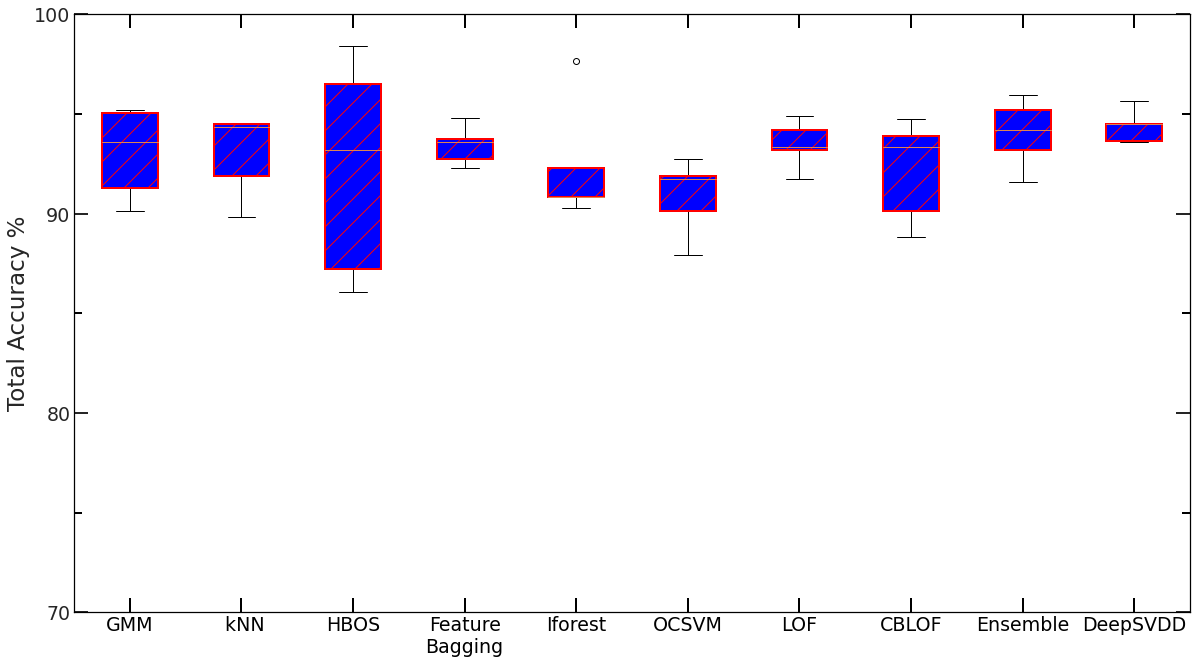

In [407]:
# Box plot with scores
#Import the accuracies table 

# Accuracy on the known data 

data1 = list(val_list_percent) #val_list
sns.set(rc={'figure.figsize':(20 ,11)})
sns.set_style("whitegrid", {'axes.grid' : False})

fig1, ax1 = plt.subplots()
ax1.set_ylim(70, 100)
#ax1.set_yticks([80, 90 ,100])
ax1.set_xticklabels(['GMM', ' kNN', 'HBOS', 'Feature\nBagging',   'Iforest', 'OCSVM',  'LOF', 'CBLOF', 'Ensemble', 'DeepSVDD' ])
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_y = np.arange(70, 100.1, 10)
minor_ticks_y = np.arange(70, 100.1, 5)

ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)

red_square = dict(markerfacecolor='r', marker='s')
bp0=ax1.boxplot(data1, patch_artist=True )#, showfliers=True, whis='range', vert=True,  flierprops=red_square)

for box in bp0['boxes']:
    # change outline color
    box.set(color='red', linewidth=2)
    # change fill color
    box.set(facecolor = 'blue' )
    # change hatch
    box.set(hatch = '/')
#plt.xlabel('One class classification models',  fontsize=18)
plt.ylabel('Total Accuracy %', fontsize=23 )
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
#plt.title('AUC=%.3f,   F1-score=%.3f' % (auc, f1) ,fontsize=18)
ax1.xaxis.label.set_color('black')
ax1.tick_params(axis='x', colors='black')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')

#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/box_plots.png', rasterized=True,  bbox_inches="tight", dpi=600)

# Scores distribution of the standard one class models

In [345]:
model_scores = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data_test/model_scores_opt.csv')       
deep_scores = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data_test/deep_scores_60_epochs.csv')   

In [413]:
model_scores

,Unnamed: 0,gmm1,knn1,hbos1,feat_bag,ifor1,ocsvm1,lof1,cblof1,ens
0,0,0.751263,0.546404,0.497650,0.822452,0.644853,0.094078,0.805063,0.686490,0.574041
1,1,0.588743,0.323876,0.314651,0.187624,0.480640,0.008174,0.251049,0.616130,0.264386
2,2,0.941213,0.924828,0.894483,0.960273,0.958330,0.735348,0.954725,0.866318,0.942118
3,3,0.766104,0.582088,0.276221,0.679705,0.383064,0.158566,0.629536,0.763898,0.487007
4,4,0.589170,0.486684,0.329816,0.033743,0.568065,0.031817,0.000000,0.663506,0.253526
...,...,...,...,...,...,...,...,...,...,...
25175,25175,0.672202,0.667126,0.409813,0.979475,0.718007,0.230353,0.961329,0.675459,0.651208
25176,25176,0.614345,0.640093,0.433756,0.966574,0.649558,0.171191,0.960697,0.633823,0.614197
25177,25177,0.669719,0.618586,0.448794,0.815246,0.679424,0.191921,0.847476,0.669466,0.588476
25178,25178,0.707365,0.617053,0.472736,0.810019,0.643139,0.219361,0.782204,0.702736,0.588495


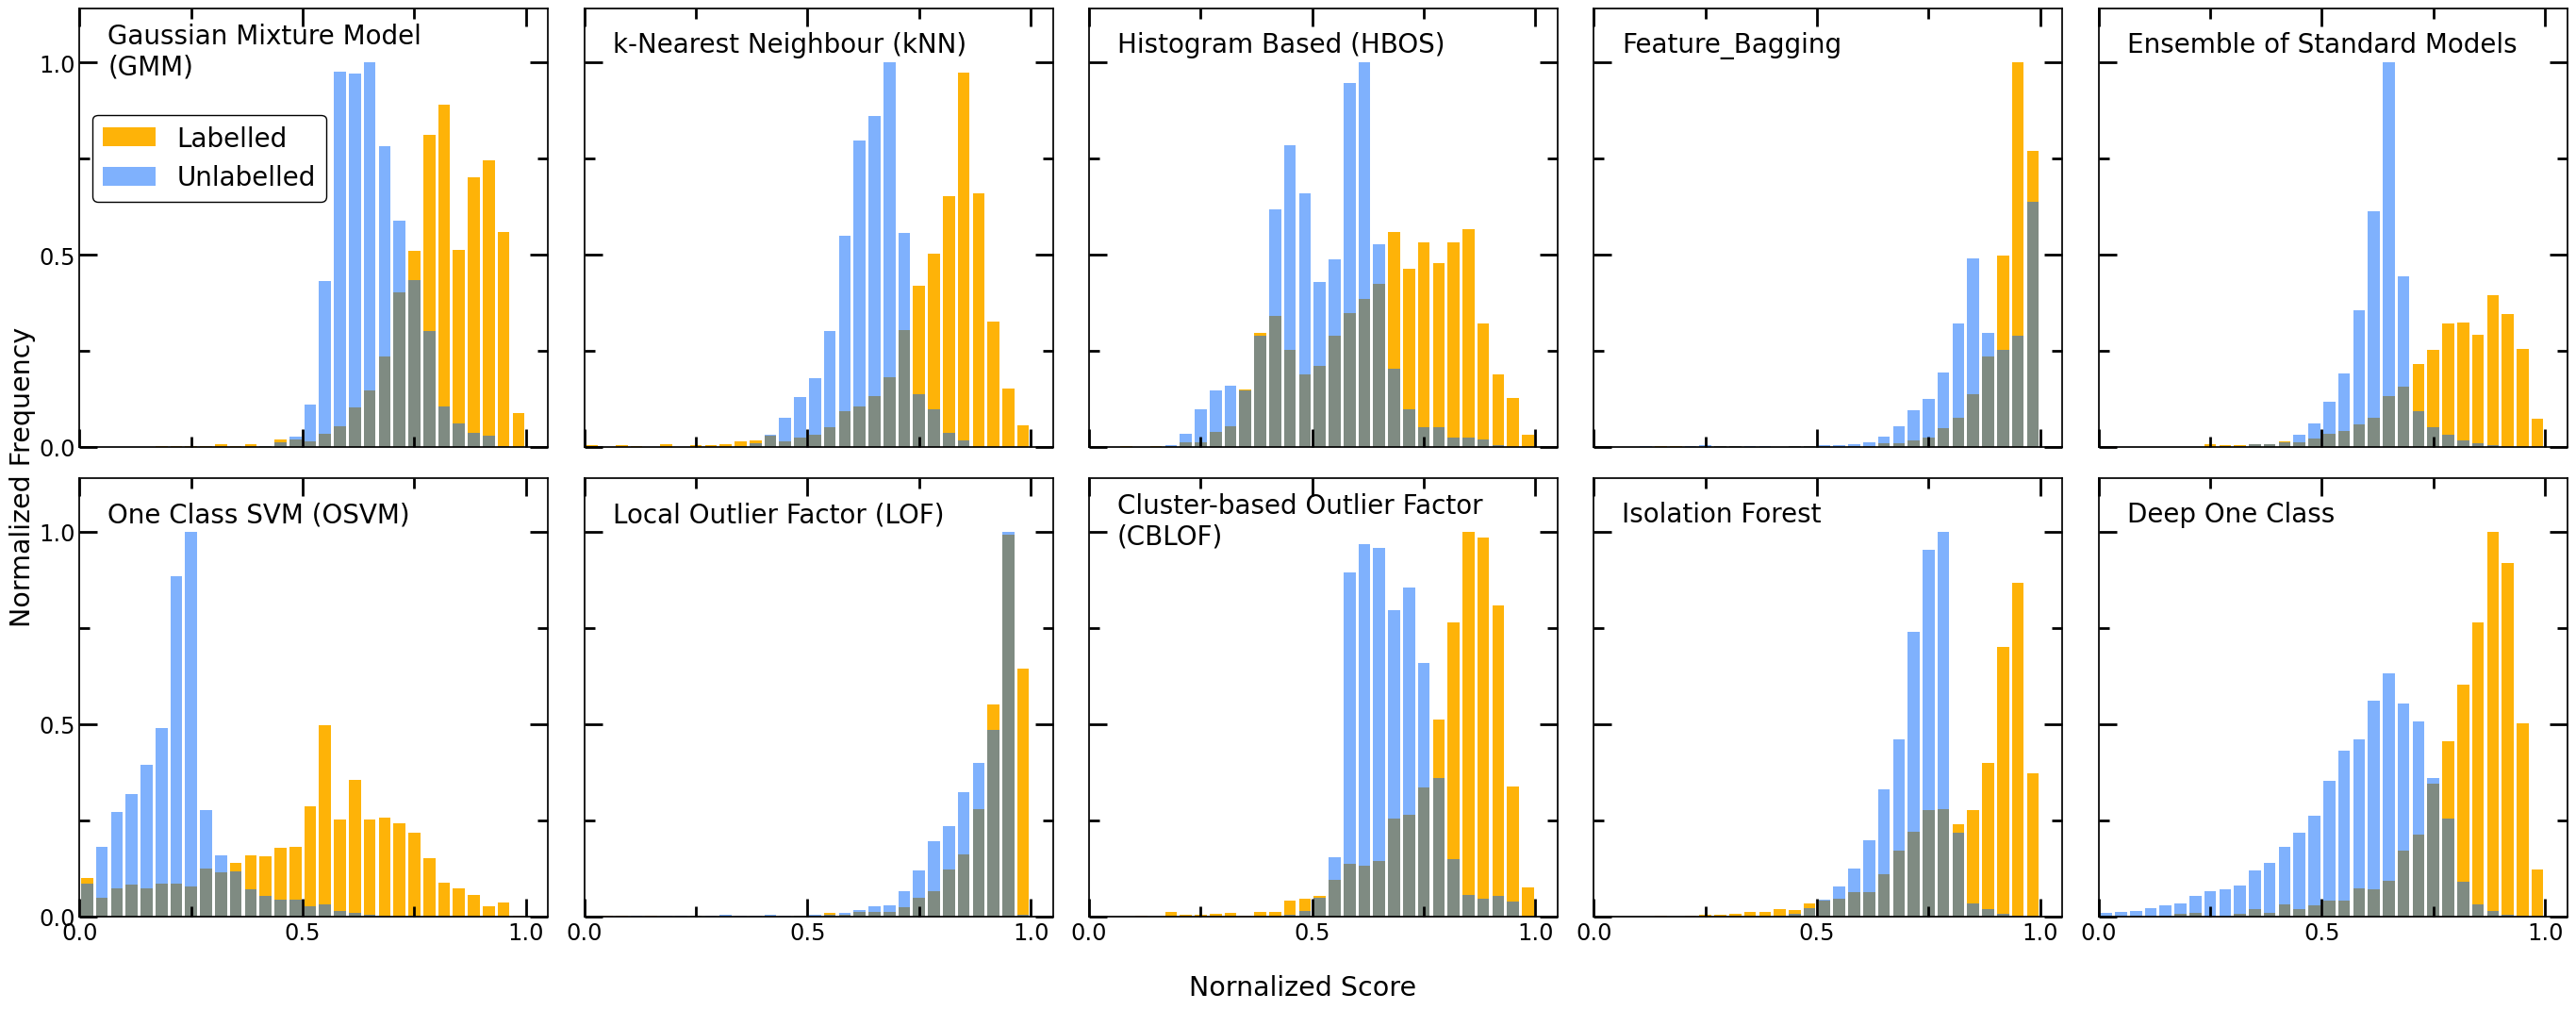

In [347]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
import matplotlib.font_manager
from matplotlib import rcParams
import matplotlib.pyplot as plt


fig, axes = plt.subplots(figsize=(26.9, 10), nrows=2, ncols=5,
                         constrained_layout=True, gridspec_kw={'wspace': 0.001, 'hspace': 0.001})

ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"] = "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"


major_ticks_x = np.arange(0, 1.1, 0.5)
minor_ticks_x = np.arange(0, 1.1, 0.25)
major_ticks_y = np.arange(0, 1.1, 0.5)
minor_ticks_y = np.arange(0, 1.1, 0.25)

n_bins = 30


def set_ticks(ax):
    ax.tick_params(axis='both', which='both', direction="in", width=2)
    ax.tick_params(axis='both', which='major', direction="in",  length=14)
    ax.tick_params(axis='both', which='minor', length=8,
                   direction="in",  color='black')
    ax.tick_params(axis='both', which='both', bottom=True,
                  top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    #ax.tick_params(axis='both', top='off', bottom='off', left='off', right='off')
    #ax.xaxis.set_ticks_position('none') 
    #ax.yaxis.set_ticks_position('none') 
    #ax.set_xticks([], minor=True)
    #ax.set_yticks([], minor=True)


def set_spines(ax):
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')


def set_prop(ax):
    ax.axis(aspect='equal')
    ax.set(adjustable='box')  # , aspect='equal')
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1.14)
    ax.grid(False)
    set_spines(ax)
    ax.set_facecolor('xkcd:white')
    ax.axis('on')
    #set_ticks(ax)

def norm_plot(ax, x, y, alpha=1, **kwargs):
    hist, bins = np.histogram(x, **kwargs)
    hist1, _ = np.histogram(y, **kwargs)
    n_max = np.max([hist, hist1])
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist / n_max, align='center', width = width, alpha=alpha)
    return hist, n_max


def lab_unlab_plot(ax, lab_d, unlab_d, n_bins):
    hist_lab, bins_lab = np.histogram(lab_d, bins=n_bins, density=True, range=(0,1))
    hist_unlab, bins_unlab = np.histogram(unlab_d, bins=n_bins, density=True, range=(0,1))
    n_max = np.max([hist_lab, hist_unlab])
    width_lab = 0.8 * (bins_lab[1] - bins_lab[0])
    width_unlab = 0.8 * (bins_unlab[1] - bins_unlab[0])
    center_lab = (bins_lab[:-1] + bins_lab[1:]) / 2
    center_unlab = (bins_unlab[:-1] + bins_unlab[1:]) / 2
    ax.bar(center_lab, hist_lab / n_max, align='center', width=width_lab, alpha=1, color='#feb308', label = 'Labelled')
    ax.bar(center_unlab, hist_unlab / n_max, align='center', width=width_unlab, alpha=0.5, color='#0165fc', label = 'Unlabelled')


# Gaussian Mixture Model
lab_unlab_plot(ax0, model_scores.gmm1[:3444], model_scores.gmm1[3444:], n_bins)
# ax0.axis(aspect='equal')
ax0.text(0.06, 0.85, 'Gaussian Mixture Model\n(GMM)',
         transform=ax0.transAxes, ha="left", fontsize=20)
#ax0.legend(prop={'size': 20}, loc=(0.02, 0.65), facecolor='white', framealpha=0)
ax0.legend(prop={'size': 20}, loc=(0.028, 0.56), facecolor='white', edgecolor='black', framealpha=1)#,  borderpad=1 ) #shadow=True, fancybox=True, loc=(0.75, -0.15),
ax0.set_xticklabels([])
#ax0.set_yticklabels([])

# knn
n_bins = 30
lab_unlab_plot(ax1, model_scores.knn1[:3444], model_scores.knn1[3444:], n_bins)
ax1.text(0.06, 0.9, 'k-Nearest Neighbour (kNN)',
         transform=ax1.transAxes, ha="left", fontsize=20)
#ax1.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

# HBOS
lab_unlab_plot(ax2, model_scores.hbos1[:3444], model_scores.hbos1[3444:], n_bins)
ax2.text(0.06, 0.9, 'Histogram Based (HBOS)',
         transform=ax2.transAxes, ha="left", fontsize=20)
#ax2.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Feature Bagging
lab_unlab_plot(ax3, model_scores.feat_bag[:3444], model_scores.feat_bag[3444:], n_bins)
ax3.text(0.06, 0.9, 'Feature_Bagging',
         transform=ax3.transAxes, ha="left", fontsize=20)
#ax3.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

# Isolation Forest
lab_unlab_plot(ax8, model_scores.ifor1[:3444], model_scores.ifor1[3444:], n_bins)
ax8.text(0.06, 0.9, 'Isolation Forest',
         transform=ax8.transAxes, ha="left", fontsize=20)
#ax8.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
#ax8.set_xticklabels([])
ax8.set_yticklabels([])

# OCSVM
lab_unlab_plot(ax5, model_scores.ocsvm1[:3444], model_scores.ocsvm1[3444:], n_bins)
ax5.text(0.06, 0.9, 'One Class SVM (OSVM)',
         transform=ax5.transAxes, ha="left", fontsize=20)
#ax5.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
#ax5.set_xticklabels([])
#ax5.set_yticklabels([])

# LOF
lab_unlab_plot(ax6, model_scores.lof1[:3444], model_scores.lof1[3444:], n_bins)
ax6.text(0.06, 0.9, 'Local Outlier Factor (LOF)',
         transform=ax6.transAxes, ha="left", fontsize=20)
#ax6.legend(prop={'size': 20}, loc=(0.02, 0.65),
 #          facecolor='white', framealpha=0)
#ax6.set_xticklabels([])
ax6.set_yticklabels([])


# CBLOF
lab_unlab_plot(ax7, model_scores.cblof1[:3444], model_scores.cblof1[3444:], n_bins)
ax7.text(0.06, 0.85, 'Cluster-based Outlier Factor\n(CBLOF)',
         transform=ax7.transAxes, ha="left", fontsize=20)
#ax7.legend(prop={'size': 20}, loc=(0.02, 0.65),
 #          facecolor='white', framealpha=0)
#ax7.set_xticklabels([])
ax7.set_yticklabels([])

# DeepSVDD
lab_unlab_plot(ax9, deep_scores.score[:1722], deep_scores.score[1722:], n_bins)
ax9.text(0.06, 0.9, 'Deep One Class',
         transform=ax9.transAxes, ha="left", fontsize=20)
#ax9.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
#ax9.set_xticklabels([])
ax9.set_yticklabels([])

# Ensemble
lab_unlab_plot(ax4, model_scores.ens[:3444], model_scores.ens[3444:], n_bins)
ax4.text(0.06, 0.9, 'Ensemble of Standard Models', 
        transform=ax4.transAxes, ha="left", fontsize=20)
#ax4.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

for ax in axes.flatten():
  set_prop(ax)
  set_ticks(ax)

fig.tight_layout()


fig.text(0.5, -0.05, 'Nornalized Score', ha='center',fontsize=20.5 )
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', fontsize=20.5)
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/figure2_new.png', rasterized=True,  bbox_inches="tight", dpi=600)

plt.show()


# Scores correlation between deep one class and the ensemble

In [414]:
ens =pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data_test/ensemble_scores_opt.csv')
ens = ens.scores.values

In [415]:
from scipy import stats
deep=deep_scores.score.values
data = pd.concat([pd.DataFrame(deep, columns=['deep']), pd.DataFrame(ens, columns=['ens'])], axis=1)
data=data[data.deep>0]
data1 = data[data.deep>0.7]
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data.deep+intercept
tzaki = pd.concat([pd.DataFrame(data.deep.values, columns=['deep']), pd.DataFrame(line.values, columns=['line'])], axis=1)

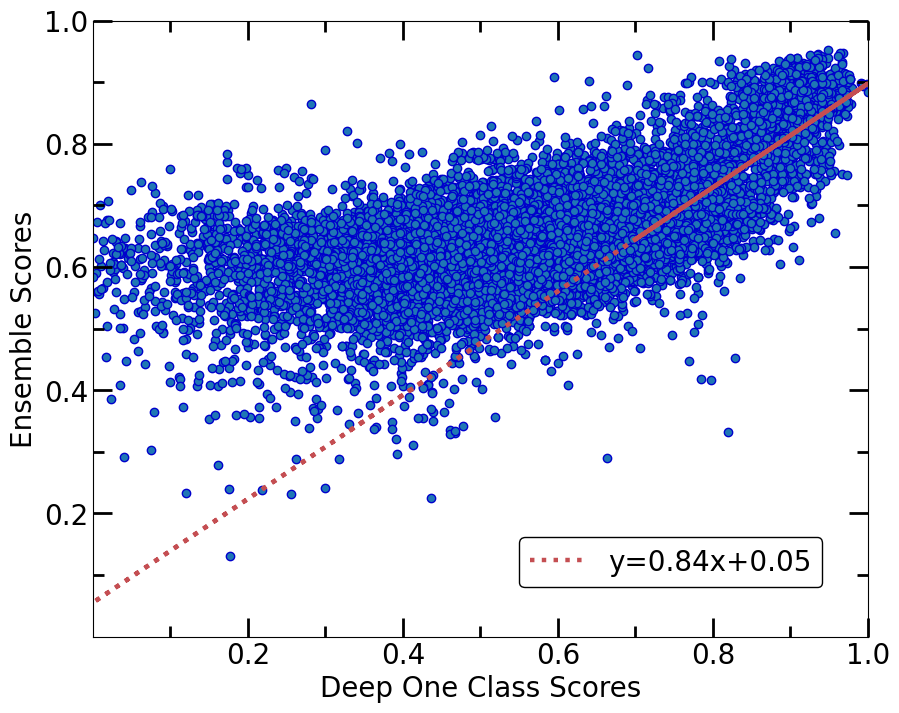

In [416]:
from matplotlib import rc
import seaborn as sns
import matplotlib.font_manager
#plt.rcParams["font.weight"] = "light"
#plt.rcParams["axes.labelweight"] = "light"
plt.rcParams['axes.facecolor'] = 'white'


plt.style.use('default')
import matplotlib.font_manager
rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "normal"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False

#fig = plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(10,8))
rcParams["axes.edgecolor"] = "0.15"
rcParams["axes.linewidth"]  = 1.25

plt.scatter(data.deep, data.ens, edgecolors='#0000CC')
slope, intercept, r_value, p_value, std_err = stats.linregress( data.deep , data.ens)
line = slope*deep+intercept
#plt.plot(deep, line, 'r', linewidth=3.0, label='y={:.2f}x+{:.2f}'.format(slope,intercept))

#plt.legend(loc='lower right')

plt.grid(False)

plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Ensemble Scores', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
# this is an inset axes over the main axes
#a = plt.axes([.6, .15, .28, .28], facecolor='white')
#sns.regplot(x="deep", y="ens", data=data1, color='b',
 #line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), 'color': 'red'})

#plt.scatter(data1.deep, data1.ens, edgecolors='#0000CC')
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data.deep+intercept
#plt.plot(data.deep, line,  'r', linestyle='-', linewidth=3.0, dashes=(5, 2), label='y1={:.2f}x+{:.2f}'.format(slope,intercept))
plt.plot(tzaki[tzaki.deep > 0.7].deep,tzaki[tzaki.deep > 0.7].line, 'r-',  linewidth=3.2)
plt.plot(tzaki[tzaki.deep < 0.7].deep,tzaki[tzaki.deep < 0.7].line, 'r:',  linewidth=3.2, label='y={:.2f}x+{:.2f}'.format(slope,intercept))


slope, intercept, r_value, p_value, std_err = stats.linregress( data.deep , data.ens)
line = slope*deep+intercept

#plt.plot(deep, line, 'r', linewidth=3.0, label='y1={:.2f}x+{:.2f}'.format(slope,intercept))

major_ticks_x = np.arange(0, 1.001, 0.2)
minor_ticks_x = np.arange(0, 1.001, 0.1)
major_ticks_y = np.arange(0, 1.001, 0.2)
minor_ticks_y = np.arange(0, 1.001, 0.1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax.yaxis.get_major_ticks()[0].draw = lambda *args:None
#plt.title('Probability')
#plt.xticks([])
#plt.yticks([])
plt.legend(prop={'size': 20}, loc=(0.55, 0.08), facecolor='white', edgecolor='black', framealpha=1 )
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/scatter1_0.7.png', dpi=600)